# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#for regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error


from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

# Helper functions

In [2]:
# root mean squared log error calculation
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [3]:
# metric used on the hackathon leaderboard
def rmseAV(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))*1000

In [4]:
def submit_file(preds_test, filename='hacklive_sub.csv'):
    ss[target] = preds_test
    
    ss.to_csv(filename, index=False)

In [5]:
def predict(model, features):
    train_pred = model.predict(x_train[features])
    test_pred = np.expm1(model.predict(x_test[features]))
    
    print(rmsle(y_train, train_pred))
    print(rmsleAV(y_train, train_pred))
    
    return train_pred, test_pred

In [6]:
def run_gradient_boosting(clf, fit_params, train, test, features, target_col, N_SPLITS = 5):
    #oof - out of fold
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))

    target = target_col

    folds = StratifiedKFold(n_splits = N_SPLITS)
    stratified_target = pd.qcut(target, 10, labels = False, duplicates='drop')

    feature_importances = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n------------- Fold {fold_ + 1} -------------')

        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]

        scaler = StandardScaler()
        scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

        fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
        feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict(X_val)
        preds_test = clf.predict(X_test)

        fold_score = rmseAV(y_val, preds_val)
        print(f'\nAV metric score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS


    oofs_score = rmseAV(target, oofs)
    print(f'\n\nAV metric for oofs is {oofs_score}')

    feature_importances = feature_importances.reset_index(drop = True)
    fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
    fi.plot(kind = 'barh', figsize=(12, 6))

    return oofs, preds, fi

In [7]:
# plots the heatmap of the chosen features in the train set
def plot_heatmap(feats):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    sns.heatmap(train[feats].corr(), annot = True, ax=ax)

# Load data

In [8]:
ss = pd.read_csv('data/sample_submission.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [9]:
# Getting the shapes of the train and test set to later split them
ntrain = train.shape[0]
ntest = test.shape[0]

In [10]:
# label of the target variable
target = 'likes'

In [11]:
y_train = train[target]

In [12]:
# Concatenating training and test data for preprocessing and feature engineering
train_test = pd.concat((train.drop('likes', axis=1),test))

In [13]:
train.head()

video_id                                              title  \
0     53364  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...   
1     51040  It's Showtime Miss Q & A: Bela gets jealous of...   
2      1856  ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n  ಕ್...   
3     22618       Havana - swing cover | dodie feat. FLASHBACK   
4     74074  MUMMY NE NI KEHTA - 2  FT. 102 NOT OUT| DUDE S...   

           channel_title  category_id publish_date  \
0                 HUM TV         24.0   2017-12-12   
1  ABS-CBN Entertainment         24.0   2018-03-08   
2     SANDALWOOD REVIEWS         24.0   2018-03-26   
3            doddleoddle         10.0   2018-02-21   
4         Dude Seriously         23.0   2018-05-10   

                                                tags     views  dislikes  \
0  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...  351430.0     298.0   
1  ABS-CBN Entertainment|"ABS-CBN"|"ABS-CBN Onlin...  461508.0      74.0   
2  challenging star darshan latest news|"challeng...   40205.0     150.0   
3  havana|"cover"|"a capella"|"swing"|"dodie"|"fl...  509726.0     847.0   
4  dude|"seriously"|"friends"|"fun"|"gujarati"|"h...   74311.0      69.0   

   comment_count                                        description  \
0          900.0  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...   
1          314.0  Vice Ganda notices Bela Padilla's sudden chang...   
2          100.0  ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ    ಕ್ಲ...   
3         4536.0  Hi hi hi! here's our vid on FLASHBACK's channe...   
4          161.0  BOOK YOUR TICKETS HERE:  https://goo.gl/QxdSyg...   

  country_code    likes  
0           CA   2351.0  
1           CA   3264.0  
2           IN    580.0  
3           GB  82773.0  
4           IN   3557.0

# Null values

In [14]:
# no null values in the provided data
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37231 entries, 0 to 11169
Data columns (total 11 columns):
video_id         37231 non-null int64
title            37231 non-null object
channel_title    37231 non-null object
category_id      37231 non-null float64
publish_date     37231 non-null object
tags             37231 non-null object
views            37231 non-null float64
dislikes         37231 non-null float64
comment_count    37231 non-null float64
description      37231 non-null object
country_code     37231 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 3.4+ MB


# Exploratory Data Analysis

## Target distribution


 mu = 12580.67 and sigma = 58562.43



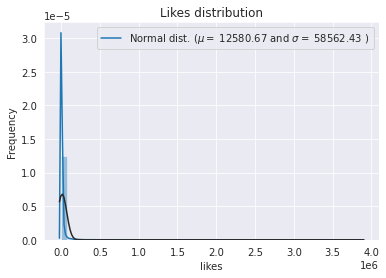

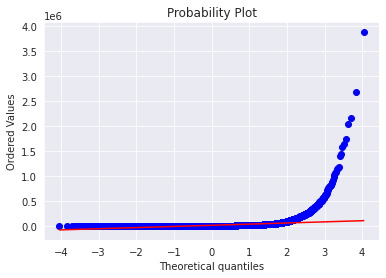

In [15]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
sns.distplot(train[target] , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Likes distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[target], plot=plt)
plt.show()

<AxesSubplot:>

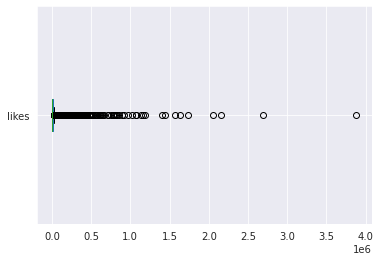

In [16]:
# box plot of the data
train[[target]].boxplot(vert=False)

Data is highly skewed which is bad for regression, so I will fix it by taking a logarithm of the target values


 mu = 7.74 and sigma = 1.93



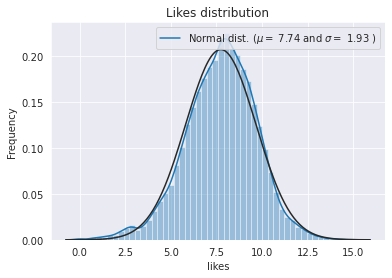

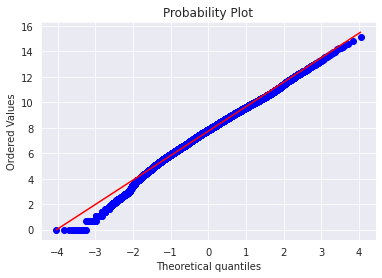

In [17]:
# fixing the skewedness (bad for regression)
train[target] = np.log1p(train[target])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[target])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
sns.distplot(train[target] , fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Likes distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[target], plot=plt)
plt.show()

<AxesSubplot:>

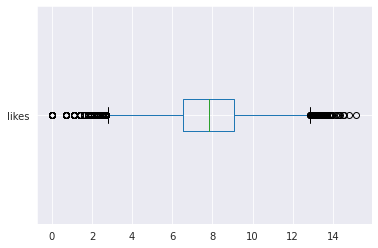

In [18]:
# box plot of the data
train[[target]].boxplot(vert=False)

As can be seen in the graphs above, the distribution of the target values is no longer skewed

## Types of available data

In [19]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37231 entries, 0 to 11169
Data columns (total 11 columns):
video_id         37231 non-null int64
title            37231 non-null object
channel_title    37231 non-null object
category_id      37231 non-null float64
publish_date     37231 non-null object
tags             37231 non-null object
views            37231 non-null float64
dislikes         37231 non-null float64
comment_count    37231 non-null float64
description      37231 non-null object
country_code     37231 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 3.4+ MB


In [20]:
train.head(1)

video_id                                              title channel_title  \
0     53364  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...        HUM TV   

   category_id publish_date  \
0         24.0   2017-12-12   

                                                tags     views  dislikes  \
0  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...  351430.0     298.0   

   comment_count                                        description  \
0          900.0  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...   

  country_code     likes  
0           CA  7.763021

Dataset contains 4 types of data: numerical, categorical, datetime and textual

## Unique values in the dataset

In [21]:
train_test.nunique()

video_id         37231
title            37127
channel_title     6979
category_id         17
publish_date       399
tags             30362
views            35792
dislikes          3123
comment_count     5937
description      33160
country_code         4
dtype: int64

## Numerical columns

In [22]:
# columns with numerical data
num_cols = ['views','dislikes','comment_count']

In [23]:
skewed_feats = train_test[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewed_features = skewed_feats.index
skewness.head(10)


Skew in numerical features: 



Skew
dislikes       66.239838
views          39.741590
comment_count  31.858783

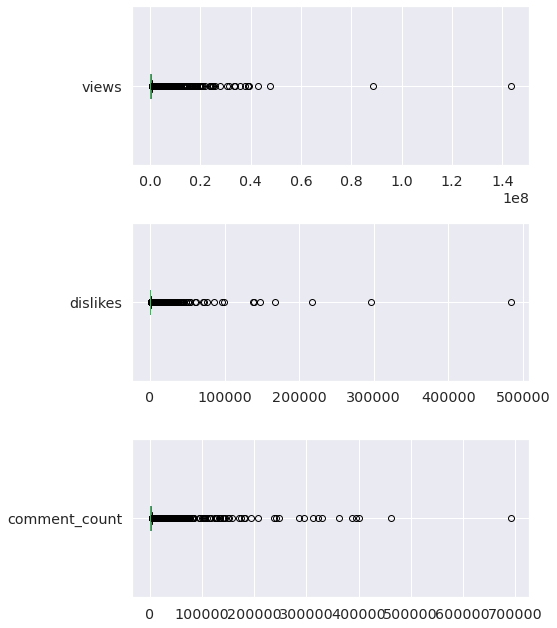

In [24]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 1, figsize=(8, 9))
for i, c in enumerate(num_cols):
    plot = train_test[[c]].boxplot(ax=axes[i], vert=False)
plt.tight_layout()

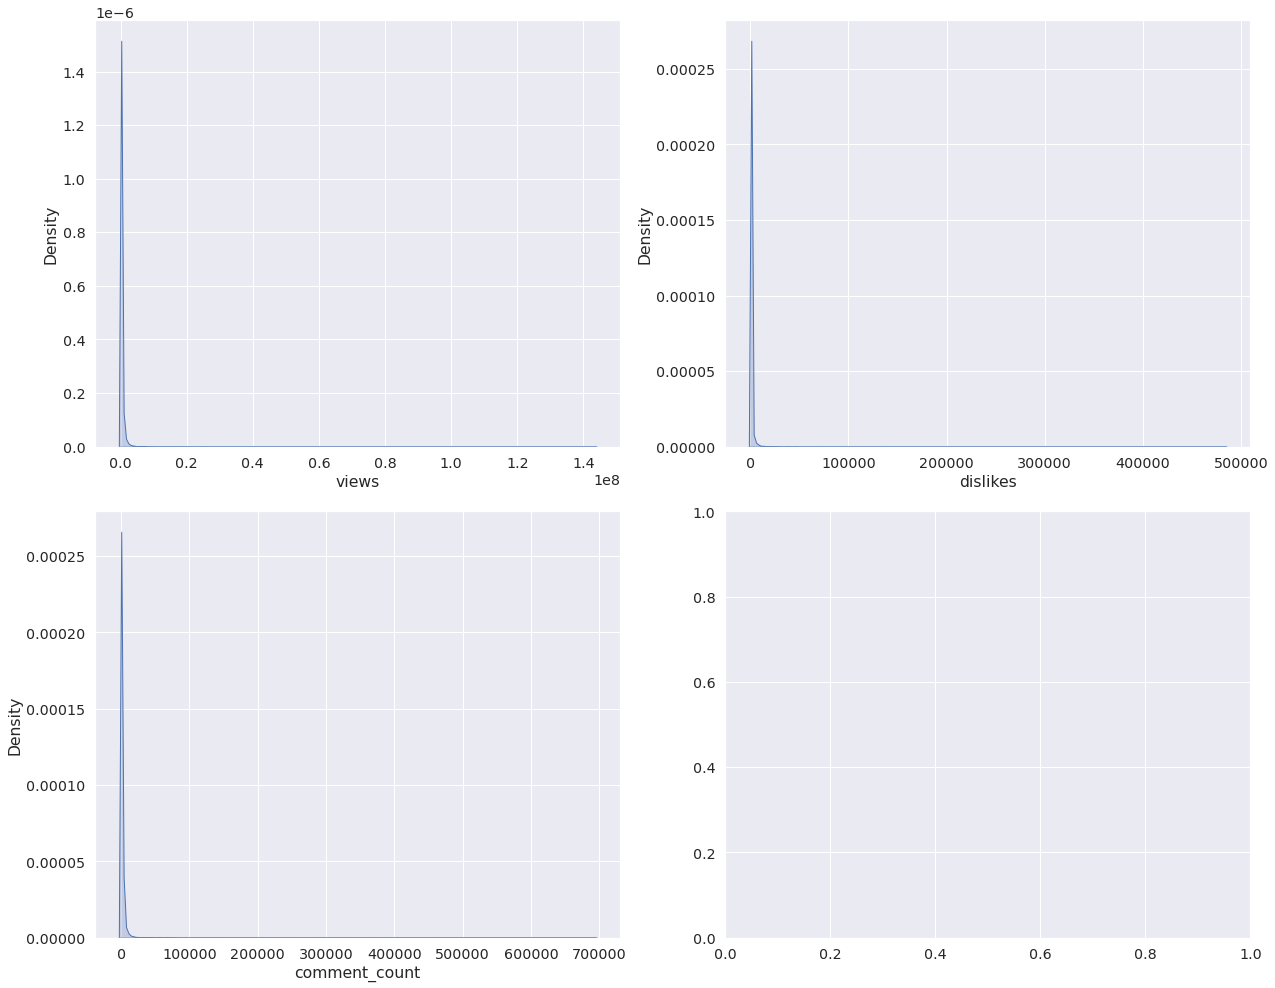

In [25]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
    plot = sns.kdeplot(data=train_test, x=c, ax=axes[i], fill=True)
plt.tight_layout()

Similarly like the target variable, the numerical features are also highly skewed so I'll take their logarithm as well

In [26]:
train_test[skewed_features] = np.log1p(train_test[skewed_features])

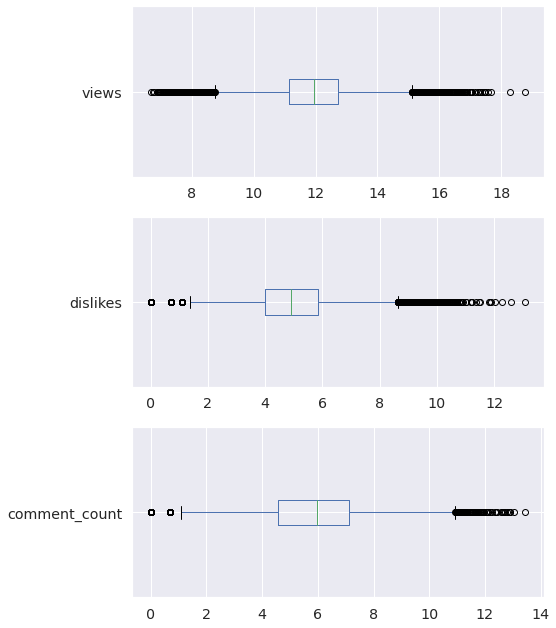

In [27]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 1, figsize=(8, 9))
for i, c in enumerate(num_cols):
    plot = train_test[[c]].boxplot(ax=axes[i], vert=False)
plt.tight_layout()

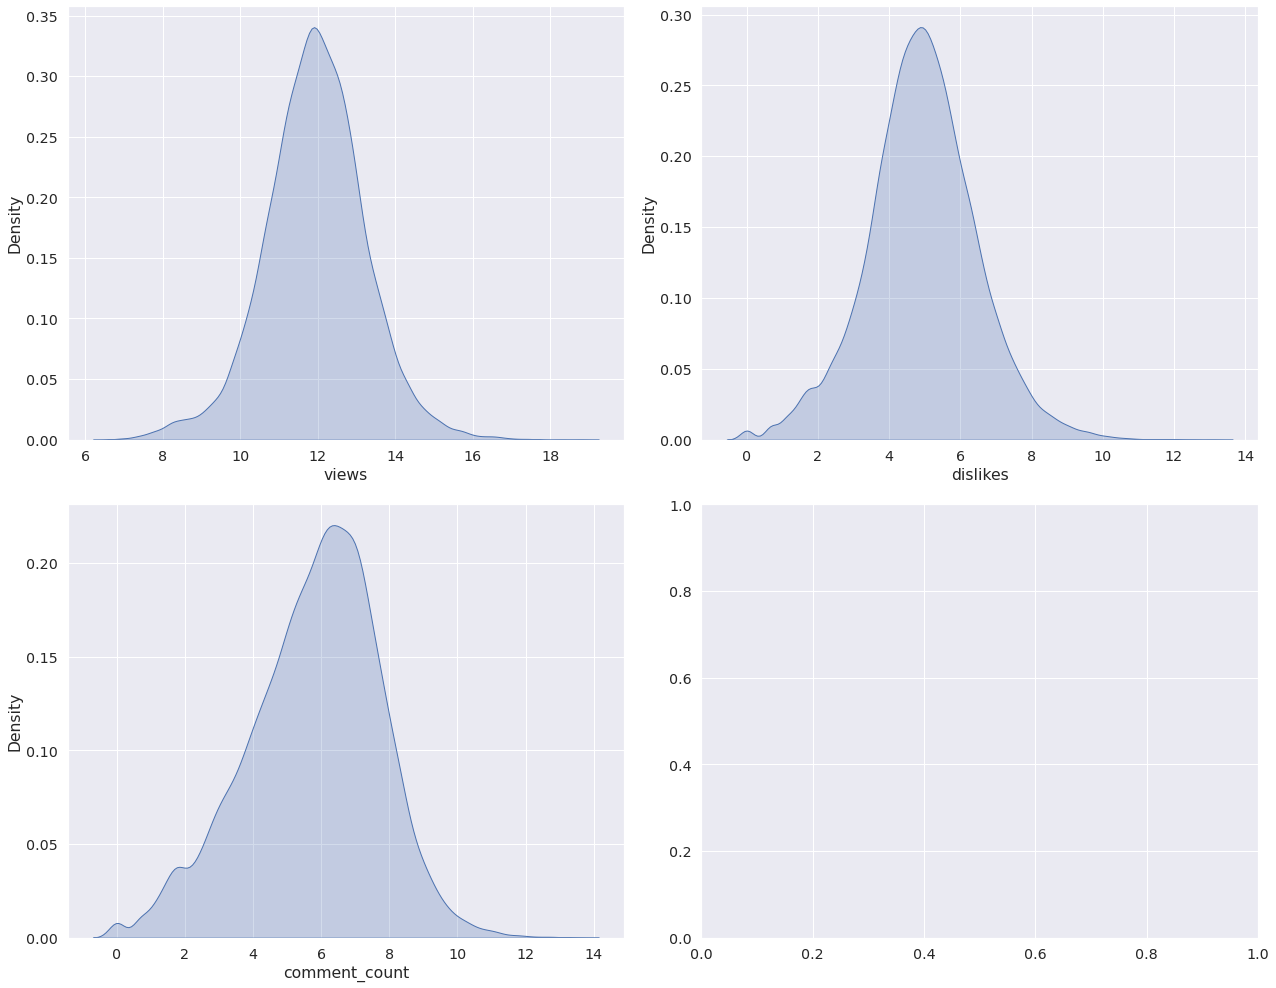

In [28]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
    plot = sns.kdeplot(data=train_test, x=c, ax=axes[i], fill=True)
plt.tight_layout()

Correlation between the numerical variables

In [29]:
train = pd.concat((train_test[:ntrain],train[target]),axis=1)

<AxesSubplot:>

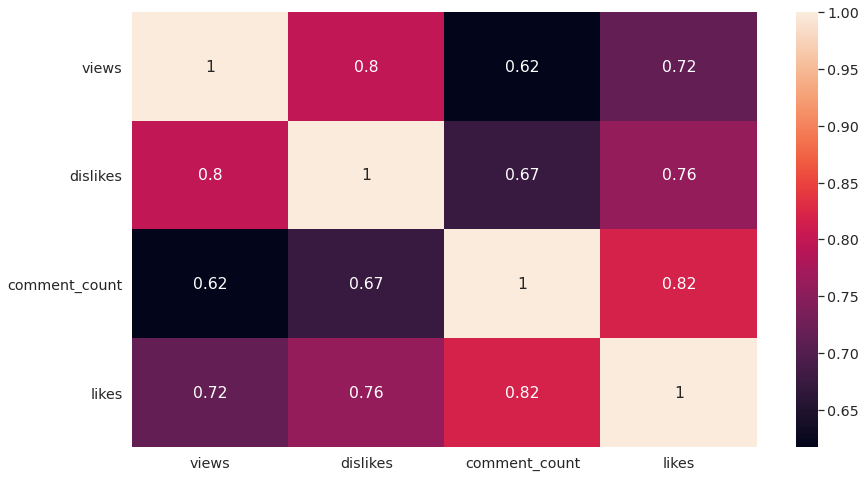

In [30]:
plt.figure(figsize=(14, 8))
sns.heatmap(train[num_cols + [target]].corr(), annot=True)

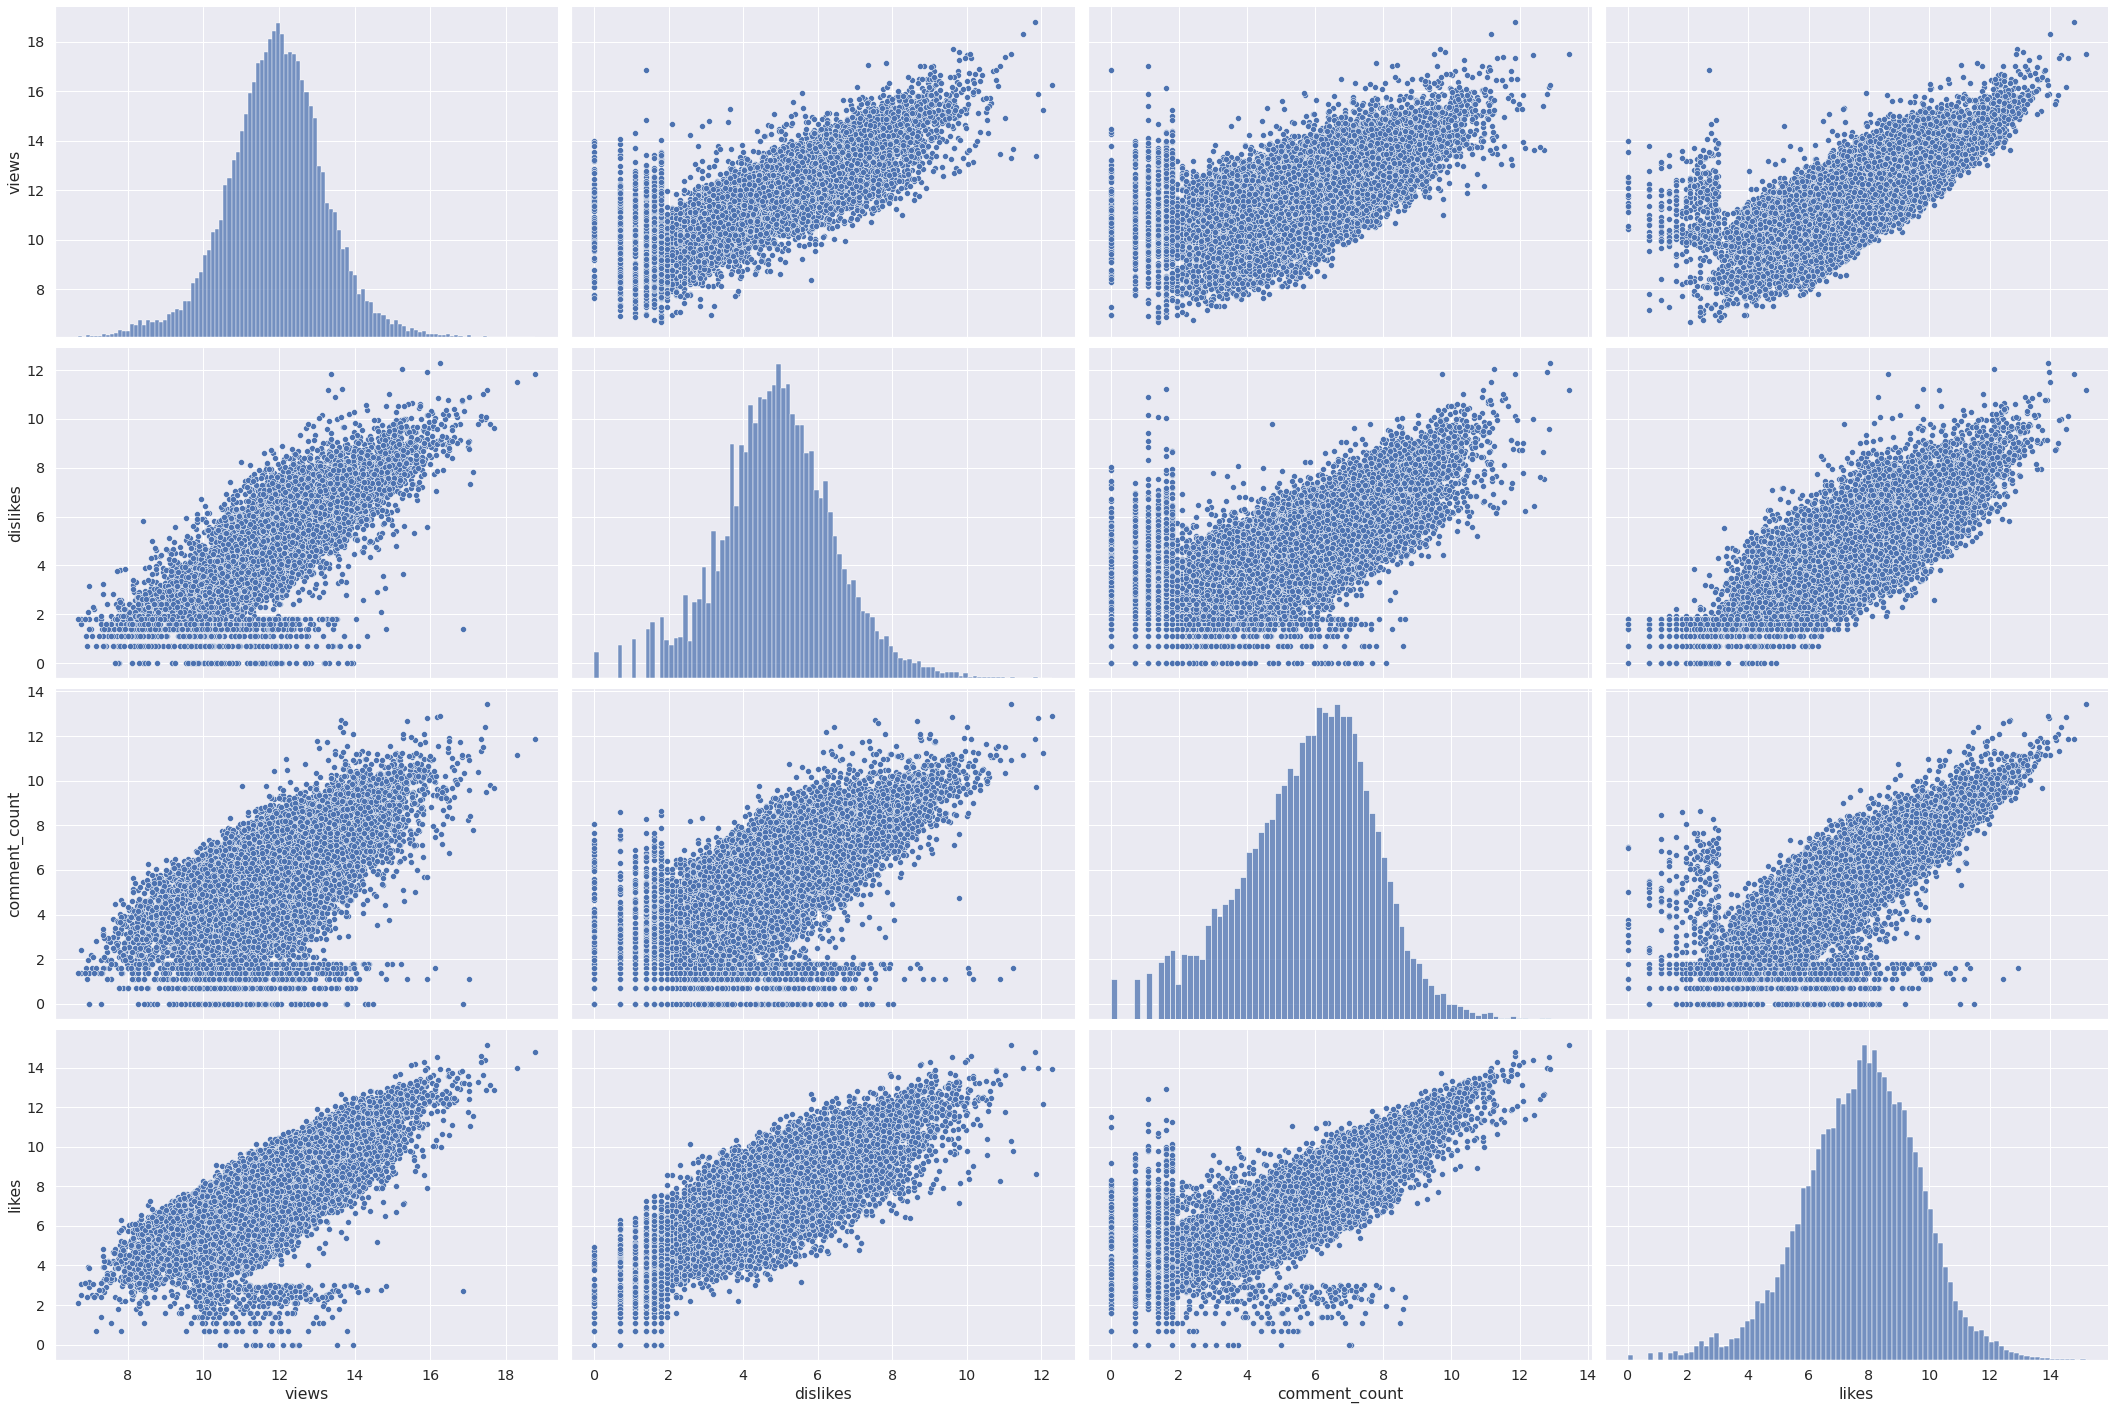

In [31]:
sns.pairplot(train[num_cols + [target]], height=5, aspect=24/16)

From the plots above we can conclude that:
- videos with more views tend to get more likes (correlation 0.72)
- videos with more comments tend to get more likes (correlation 0.82)
- videos with more dislikes also tend to get more likes (correlation 0.76)

All of these variables show a pretty strong linear dependence

## Categorical variables

In [32]:
# columns with categorical data
cat_cols = ['category_id', 'country_code', 'channel_title']

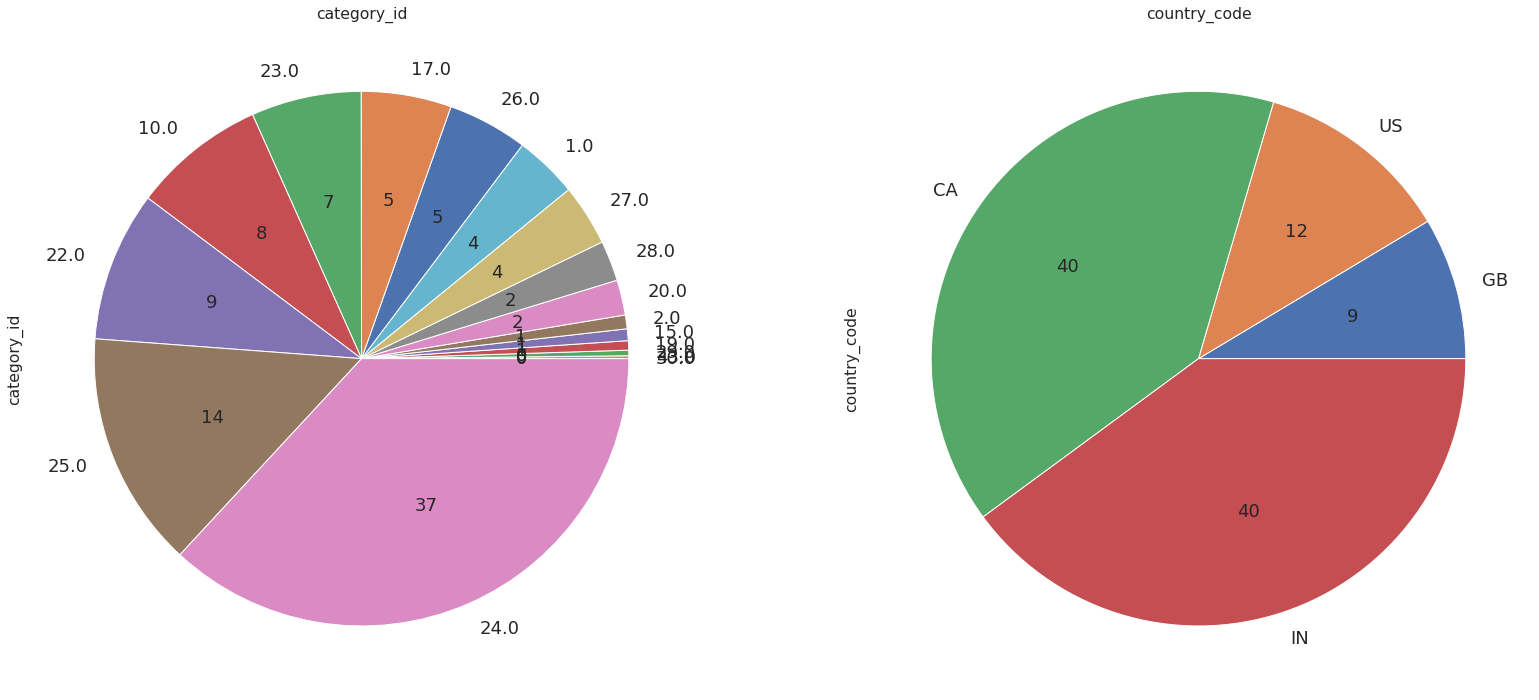

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for i, c in enumerate(train[['category_id', 'country_code']]):
    plot = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=18)
    
plt.tight_layout()

- Most of the videos (37%) belong to the category 24
- 40% of videos come from Canada and the same amount from India

## Channels with the most videos worldwide

In [34]:
top20_channels = train['channel_title'].value_counts()[:20].reset_index()
top20_channels.columns = ['channel_title','num_videos']

In [35]:
top20_channels

channel_title  num_videos
0               SAB TV         165
1            SET India         128
2                 ESPN         122
3   Study IQ education         118
4       etvteluguindia         115
5            Tarang TV         102
6      The Young Turks         101
7            Colors TV          99
8       ETV Plus India          98
9          zeetvtelugu          96
10   Mazhavil Manorama          94
11            only ias          90
12          zeemarathi          89
13         ARY Digital          89
14      Flowers Comedy          88
15               MSNBC          88
16    Saregama TVShows          87
17                 CNN          86
18   Jimmy Kimmel Live          82
19  ETV Andhra Pradesh          82

<AxesSubplot:xlabel='num_videos', ylabel='channel_title'>

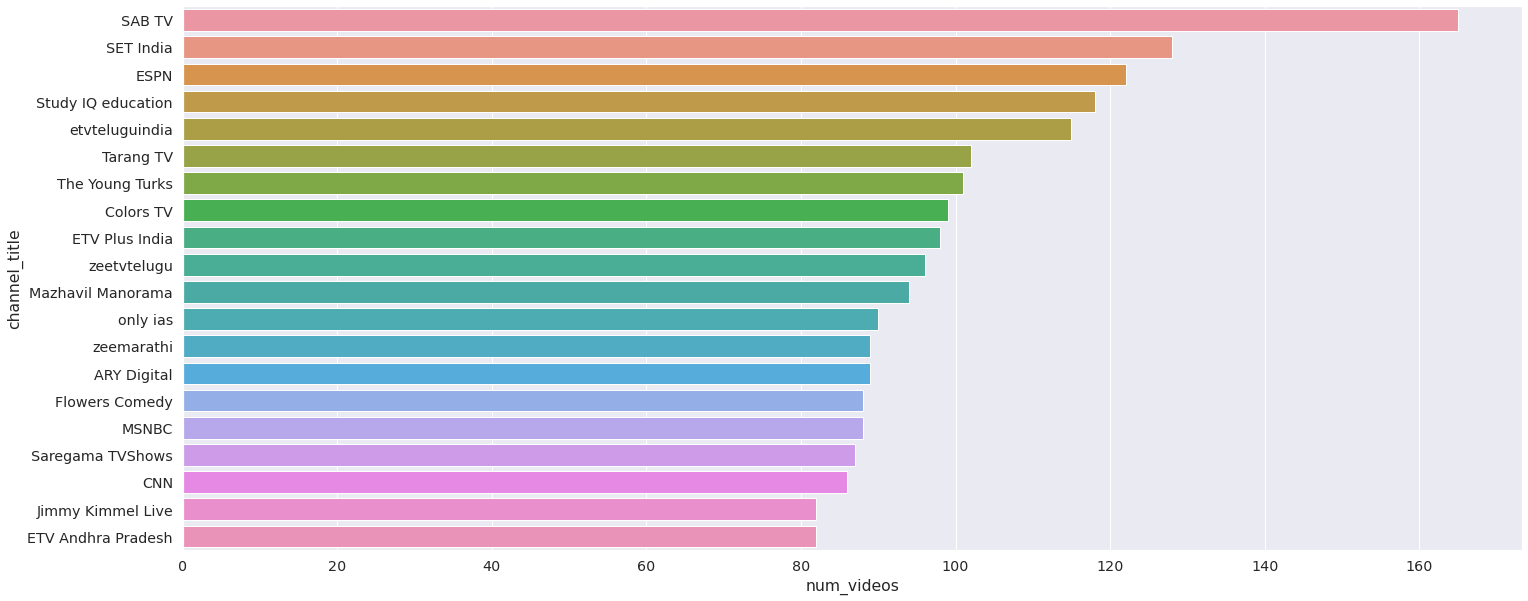

In [36]:
fig = plt.figure(figsize=(24, 10))
sns.barplot(data=top20_channels, x='num_videos', y='channel_title')

## Number of videos for channels per country

In [37]:
country_wise_channels = train.groupby(['country_code','channel_title']).size().reset_index()
country_wise_channels.columns = ['country_code', 'channel_title', 'num_videos']
country_wise_channels = country_wise_channels.sort_values(by = 'num_videos', ascending=False)

In [38]:
country_wise_channels 

country_code       channel_title  num_videos
4937           IN  Study IQ education         118
5237           IN      etvteluguindia         115
5016           IN           Tarang TV         102
2220           CA     The Young Turks         100
4254           IN           Colors TV          99
...           ...                 ...         ...
2890           GB        All Time Low           1
2889           GB       Alissa Ashley           1
2888           GB               Ali-A           1
2886           GB              Alesso           1
6674           US                 郭韋辰           1

[6675 rows x 3 columns]

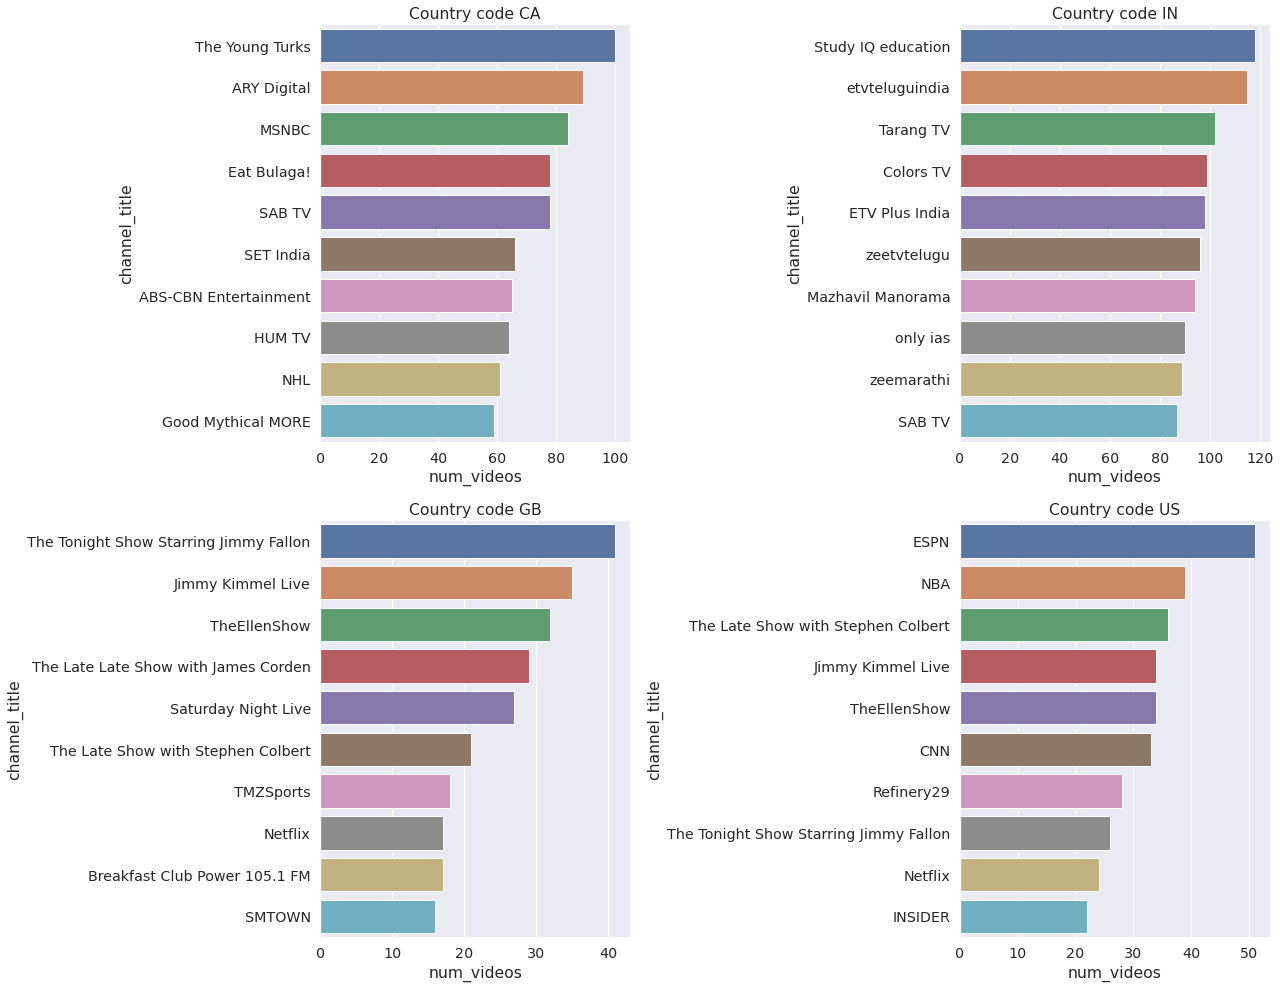

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train['country_code'].unique()):
    country = country_wise_channels[country_wise_channels['country_code']==c][:10]
    sns.barplot(data=country, x='num_videos', y='channel_title', ax = axes[i])
    axes[i].set_title(f'Country code {c}')
plt.tight_layout()

## Number of likes for channels per country

In [40]:
country_wise_channels = train.groupby(['country_code', 'channel_title'])['likes'].max().reset_index()
country_wise_channels = country_wise_channels.sort_values(by = ['likes'], ascending=False)

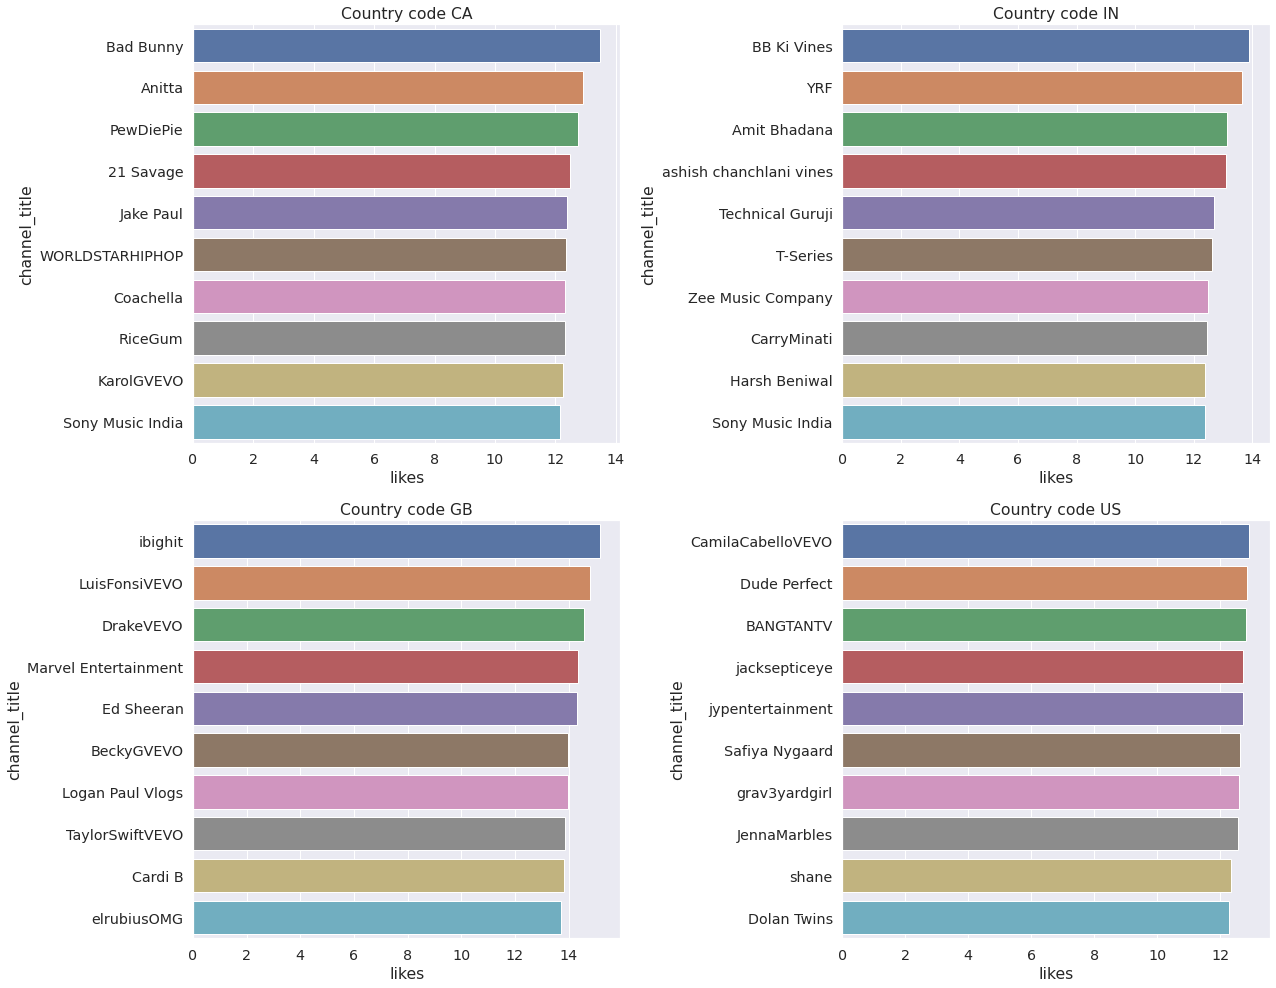

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]


for i, c in enumerate(train['country_code'].unique()):
    country = country_wise_channels[country_wise_channels['country_code']==c][:10]
    sns.barplot(data=country, x='likes', y='channel_title', ax = axes[i])
    axes[i].set_title(f'Country code {c}')
plt.tight_layout()

It can be clearly seen that belonging to a specific channel can affect the number of likes a video can get, so that should be included in the model.

## Distribution of likes per category

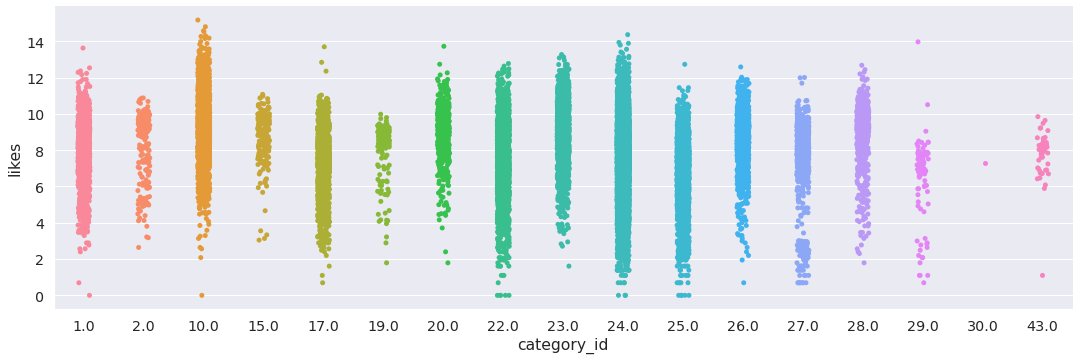

In [42]:
sns.catplot(data=train, x='category_id', y='likes', height=5, aspect=24/8)

The amount of likes a video gets appears to depend in some way on its category so that should be included in the model.

## Distribution of likes per country

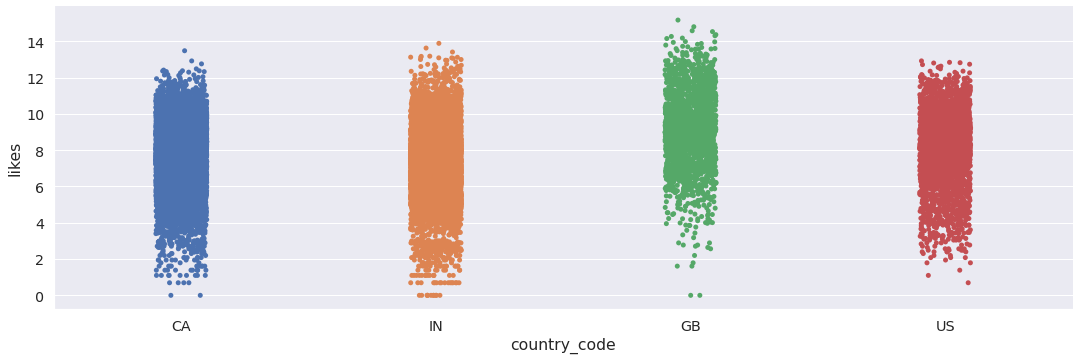

In [43]:
sns.catplot(data=train, x='country_code', y='likes', height=5, aspect=24/8)

<AxesSubplot:ylabel='country_code'>

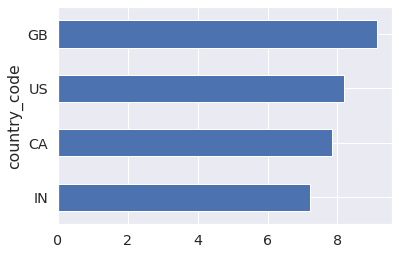

In [44]:
train.groupby('country_code')['likes'].mean().sort_values().plot(kind='barh')

Country of origin also seems to have some effect on the number of likes, british videos tend to receive more of them.

## Datetime features

In [45]:
train_test['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
train['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')

In [46]:
train_test['publish_date']

0       2017-12-12
1       2018-03-08
2       2018-03-26
3       2018-02-21
4       2018-05-10
           ...    
11165   2018-04-23
11166   2018-01-10
11167   2018-01-10
11168   2018-02-08
11169   2018-01-01
Name: publish_date, Length: 37231, dtype: datetime64[ns]

In [47]:
train['publish_date'].min(), train['publish_date'].max()

(Timestamp('2006-07-23 00:00:00'), Timestamp('2018-06-14 00:00:00'))

Dataset contains data between 2006 and 2018

## Number of videos per date

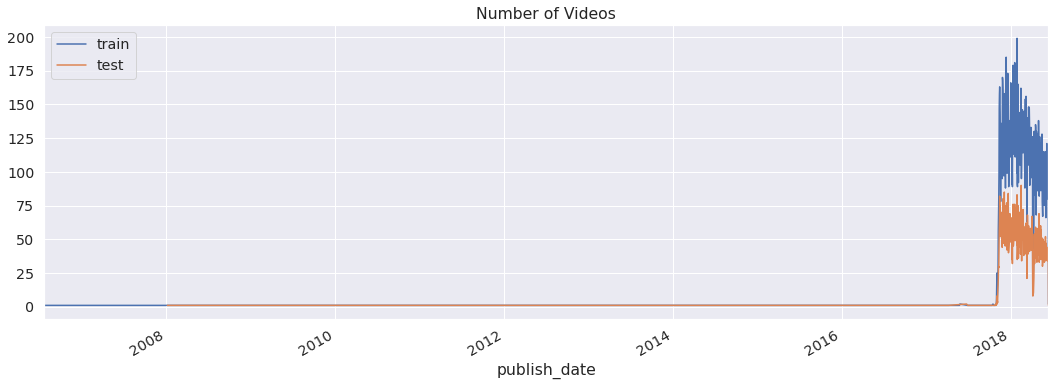

In [48]:
latest_data_train = train
latest_data_test = test
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().rename('train').plot(figsize=(18, 6), title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().rename('test').plot(figsize=(18, 6), title = 'Number of Videos')
_ = plt.legend()

Most of the videos were published in 2017 and 2018, so perhaps it makes sense to consider videos in three categories: 2018, 2017 and older than 2017

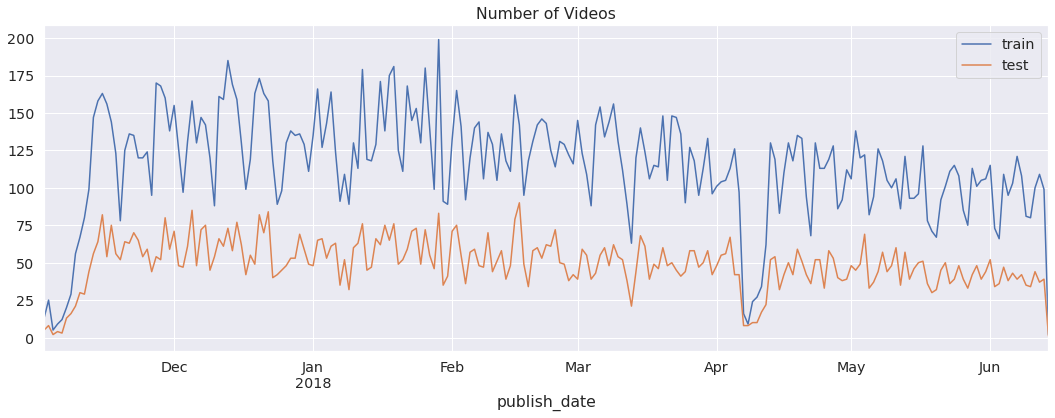

In [49]:
latest_data_train = train[train['publish_date'] > '2017-11']
latest_data_test = test[test['publish_date'] > '2017-11']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().rename('train').plot(figsize=(18, 6), title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().rename('test').plot(figsize=(18, 6), title = 'Number of Videos')
_ = plt.legend()

## Mean of likes per date

<AxesSubplot:title={'center':'Mean Likes'}, xlabel='publish_date'>

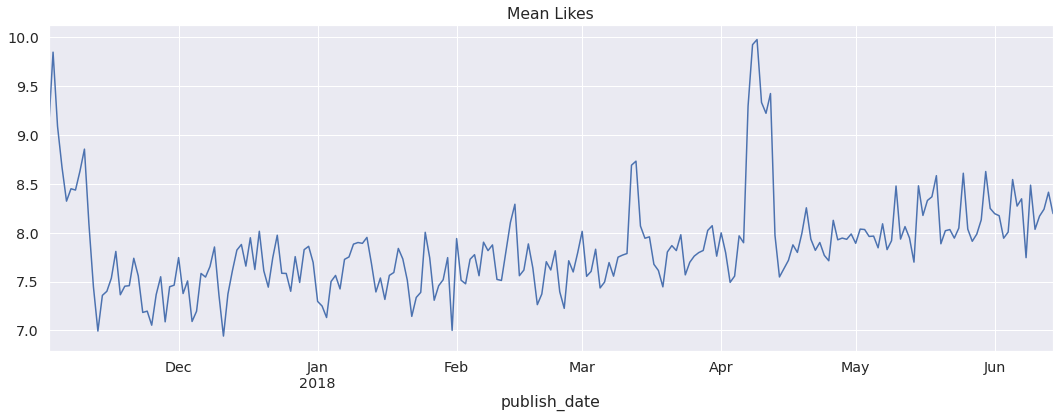

In [50]:
latest_data = train[train['publish_date'] > '2017-11']
latest_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(18, 6), title="Mean Likes")

## Number of videos per day per country

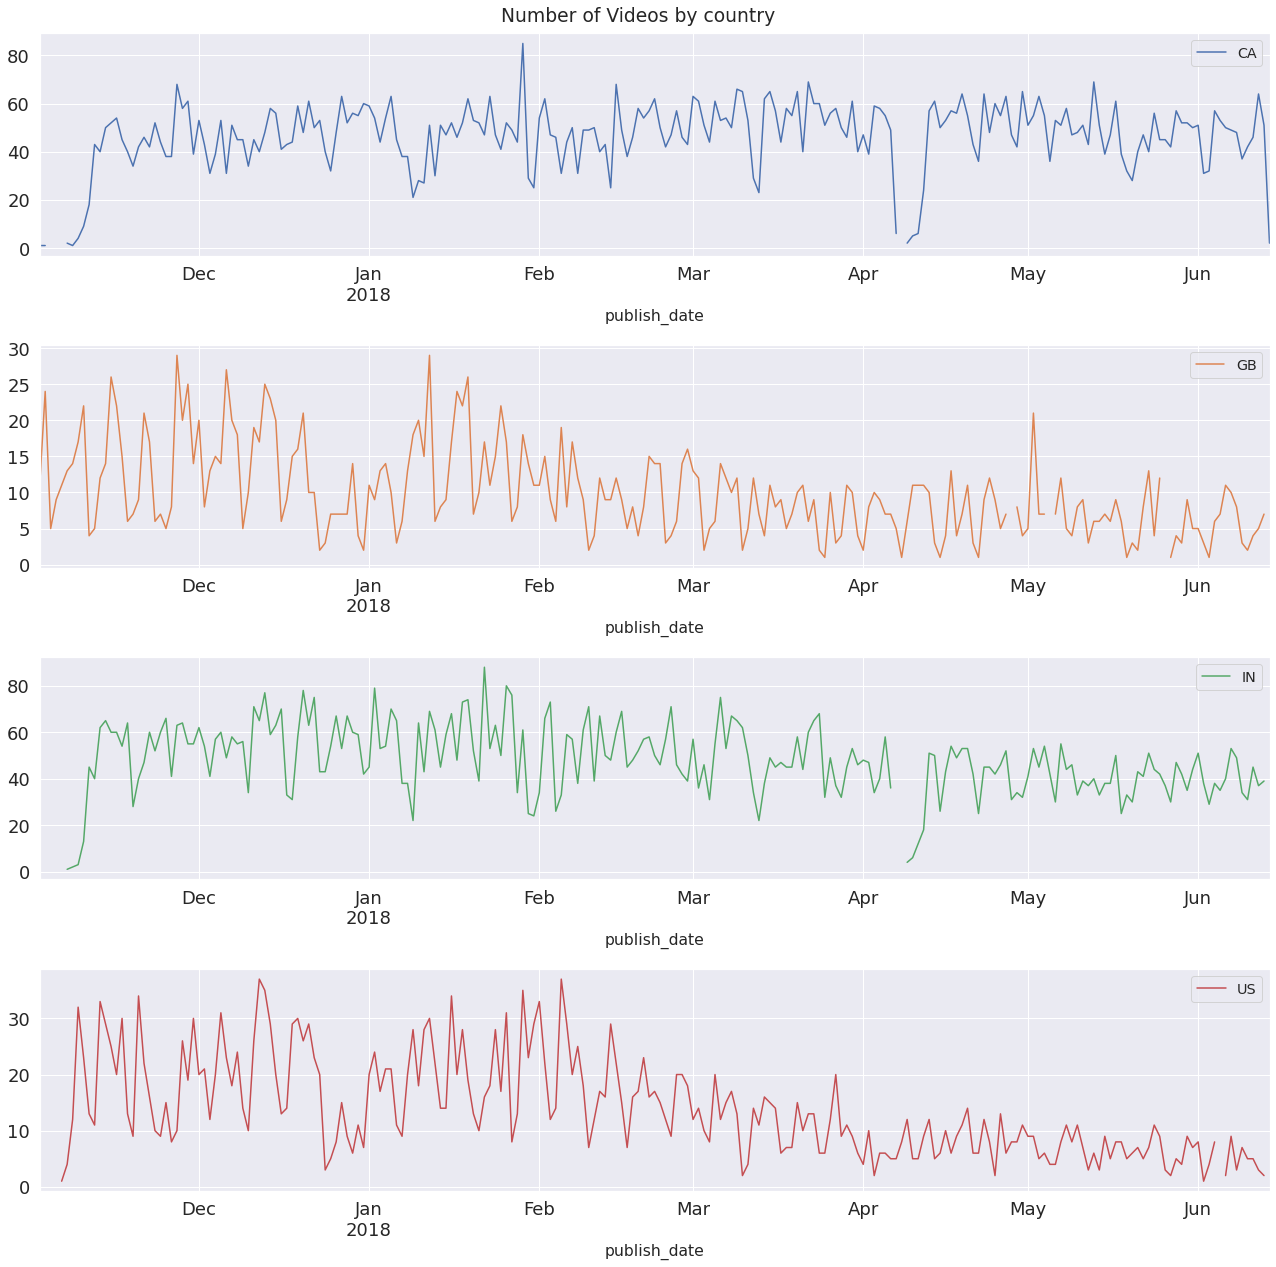

In [51]:
tmp = latest_data.groupby(['publish_date', 'country_code']).size().reset_index()
tmp.pivot_table(index = 'publish_date', columns = 'country_code', values=0).plot(subplots=True, figsize=(18, 18),
                                                                                           title='Number of Videos by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

Great Britain and US have experienced a significant drop in the number of videos over time, so the publish date may be useful for the model.

## Mean number of likes per day per country

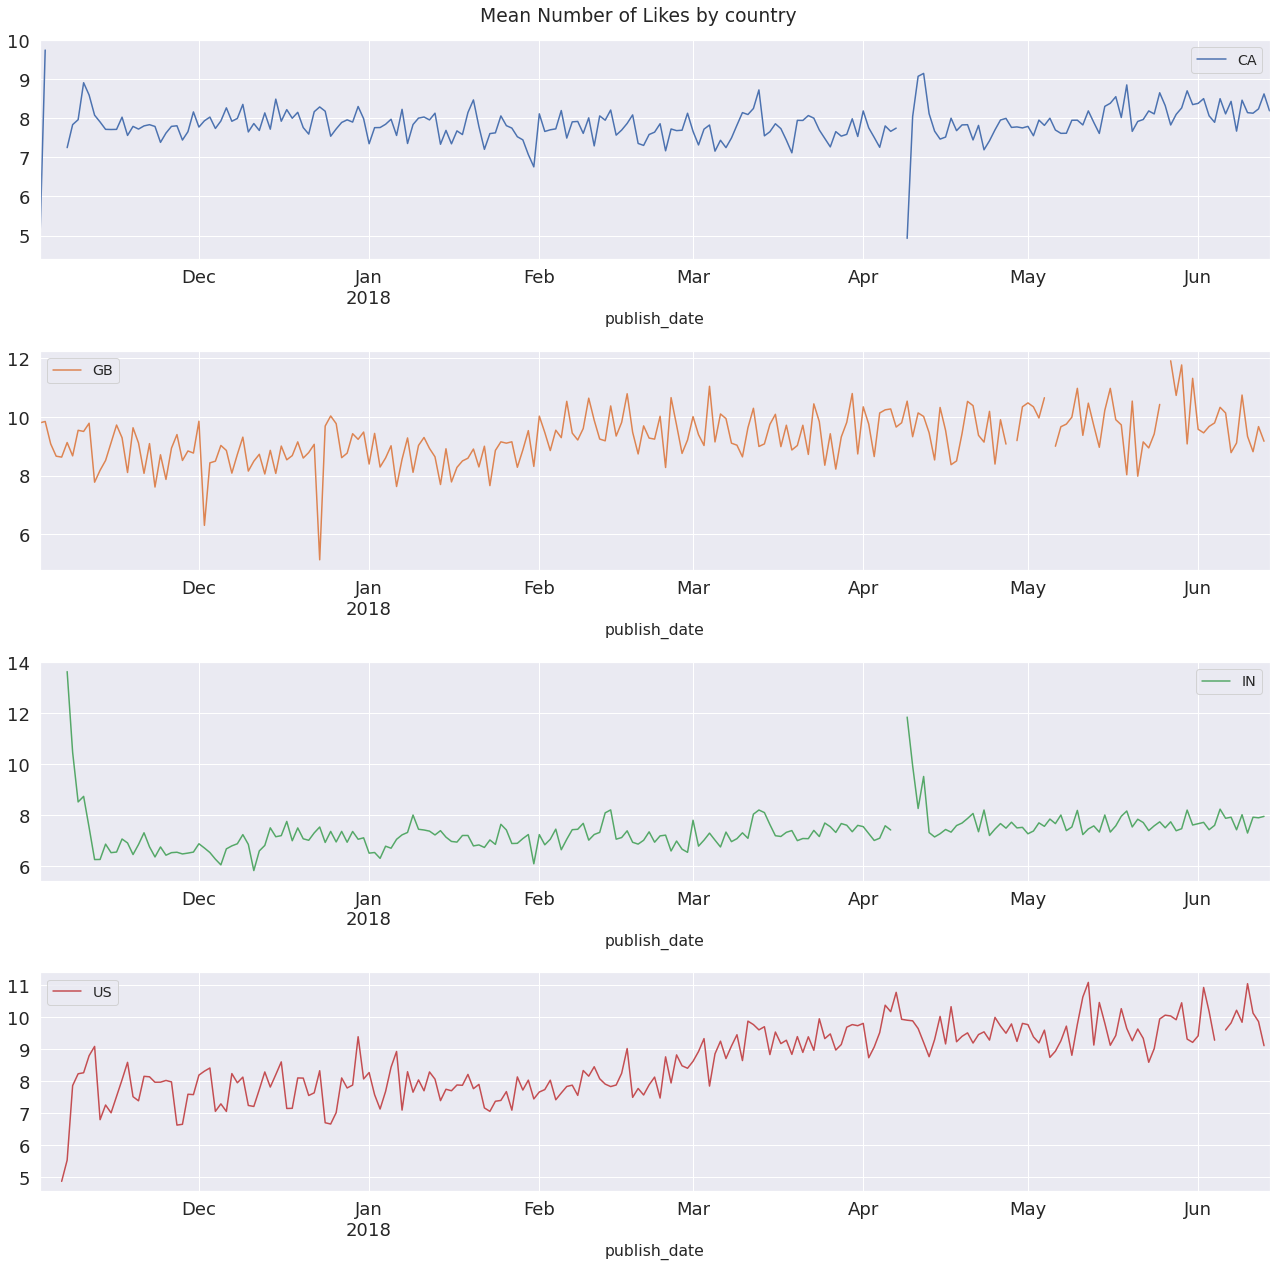

In [52]:
tmp = latest_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
tmp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, figsize=(18, 18),
                                                                                           title='Mean Number of Likes by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

Mean number of likes seems to be relatively stable over time in Canada, in other countries the mean number of likes seems to be growing slightly over time, so newer videos should on average receive more likes, especially in the US.

## Influence of the day of the week

In [53]:
train['dayofweek'] = train['publish_date'].dt.dayofweek

Text(0.5, 1.0, 'Number of Videos Posted Per Day of Week')

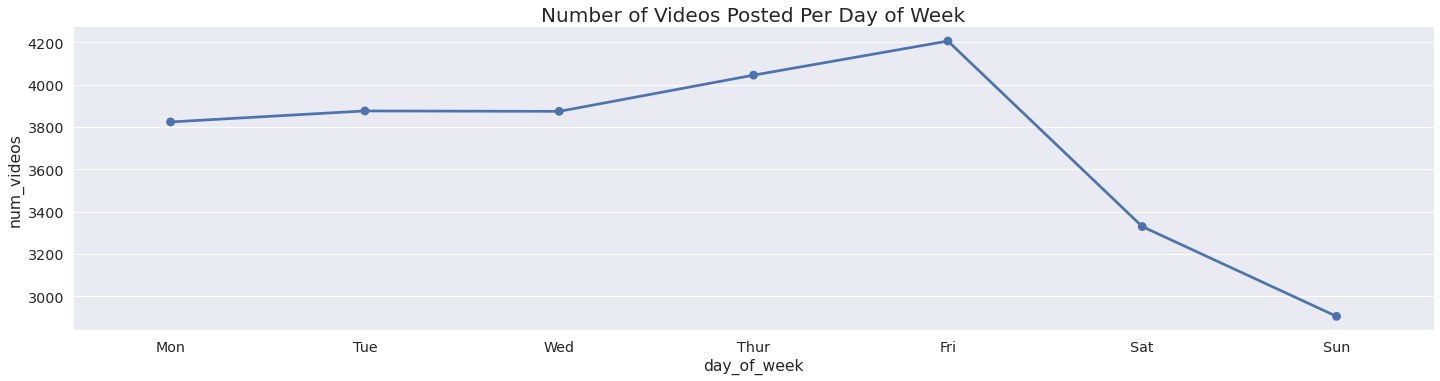

In [54]:
n_videos_per_day_of_week = train['dayofweek'].value_counts().sort_index().reset_index()
n_videos_per_day_of_week.columns = ['day_of_week', 'num_videos']
n_videos_per_day_of_week['day_of_week'] = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
sns.catplot(x = 'day_of_week', y = 'num_videos', data = n_videos_per_day_of_week, kind = 'point',aspect = 24/6)
plt.title("Number of Videos Posted Per Day of Week", fontsize=20)

Overall, a lot more videos are posted during the week than on weekends

In [55]:
mean_likes_per_day_of_week = train[['dayofweek',target]].groupby('dayofweek').mean().reset_index()
days = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days = pd.Series(days)

In [56]:
mean_likes_per_day_of_week['dayofweek'] = mean_likes_per_day_of_week['dayofweek'].map(days)

In [57]:
mean_likes_per_day_of_week

dayofweek     likes
0       Mon  7.618875
1       Tue  7.683031
2       Wed  7.766408
3      Thur  7.840179
4       Fri  7.859039
5       Sat  7.706716
6       Sun  7.666167

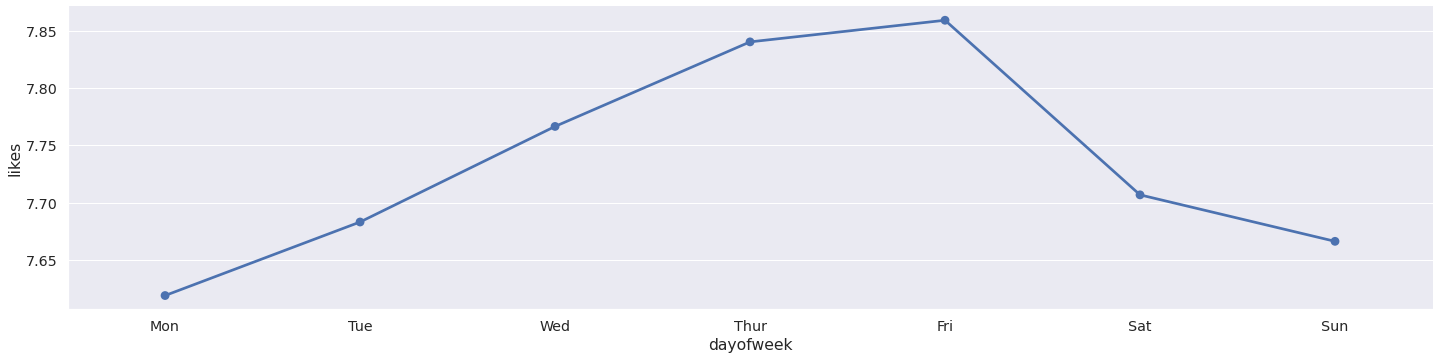

In [58]:
sns.catplot(x = 'dayofweek', y = 'likes', data = mean_likes_per_day_of_week, kind = 'point',aspect = 24/6)

The mean number of likes seems to be the highest on thursdays and fridays, right before the weekend. It appears that the day of the week on which the video was published influences the average number of likes it receives.

## Textual data

In [59]:
# columns with the textual data
text_cols = ['title', 'tags', 'description']

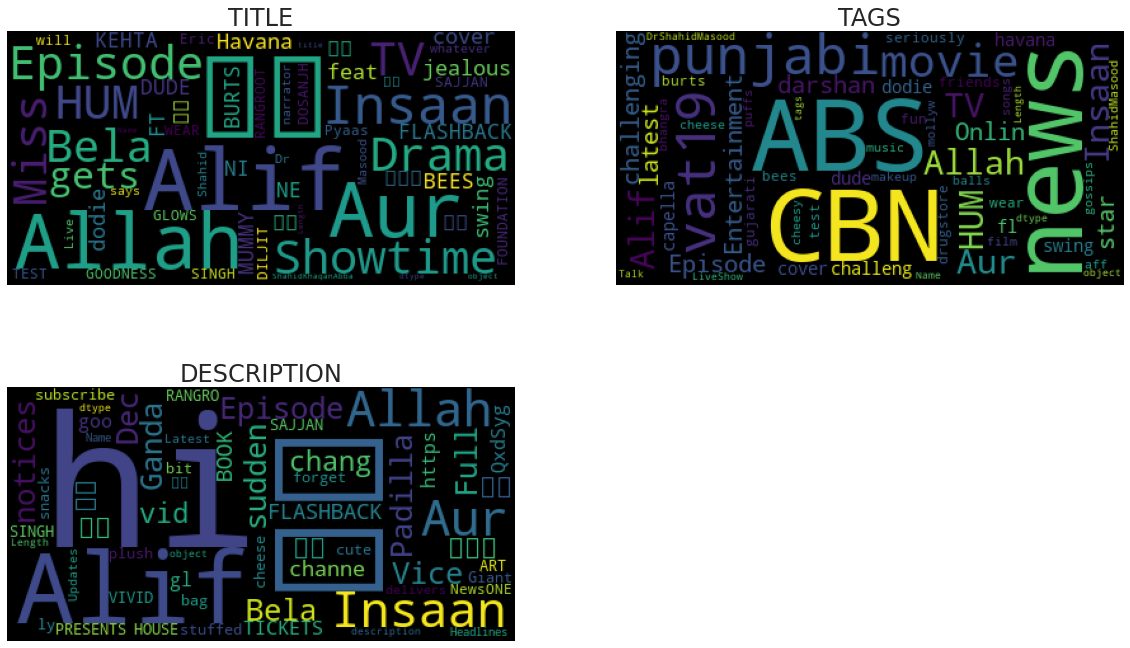

In [60]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(text_cols):
    op = wc.generate(str(train[c]))
    axes[i].imshow(op)
    axes[i].set_title(c.upper(), fontsize=24)
    axes[i].axis('off')

fig.delaxes(axes[3])

In [61]:
# plot the world cloud only for a specified country code
def plot_countrywise(country_code = 'IN'):
    country = train[train['country_code'] == country_code]
    country = country[country['likes'] > 10]
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = [ax for axes_row in axes for ax in axes_row]

    for i, c in enumerate(text_cols):
        op = wc.generate(str(country[c]))
        axes[i].imshow(op)
        axes[i].set_title(c.upper(), fontsize=24)
        axes[i].axis('off')

    fig.delaxes(axes[3])
    plt.suptitle(f"Country Code: '{country_code}'", fontsize=30)

### Wordclouds for each region for most liked videos

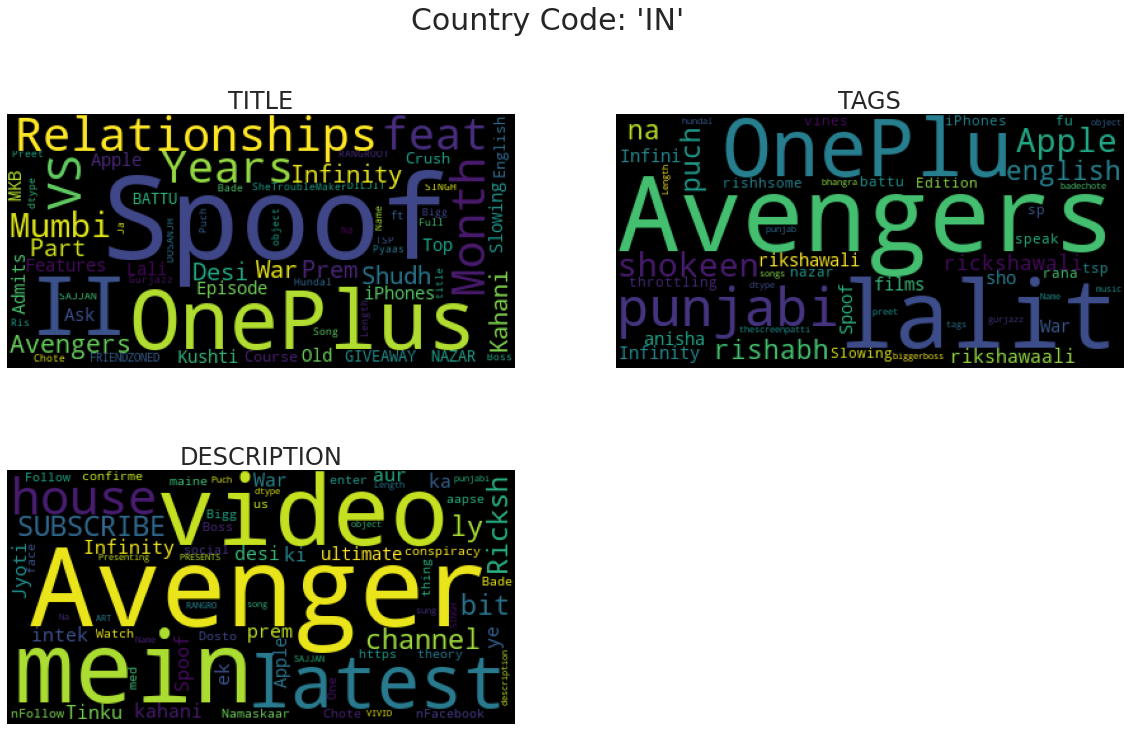

In [62]:
plot_countrywise('IN')

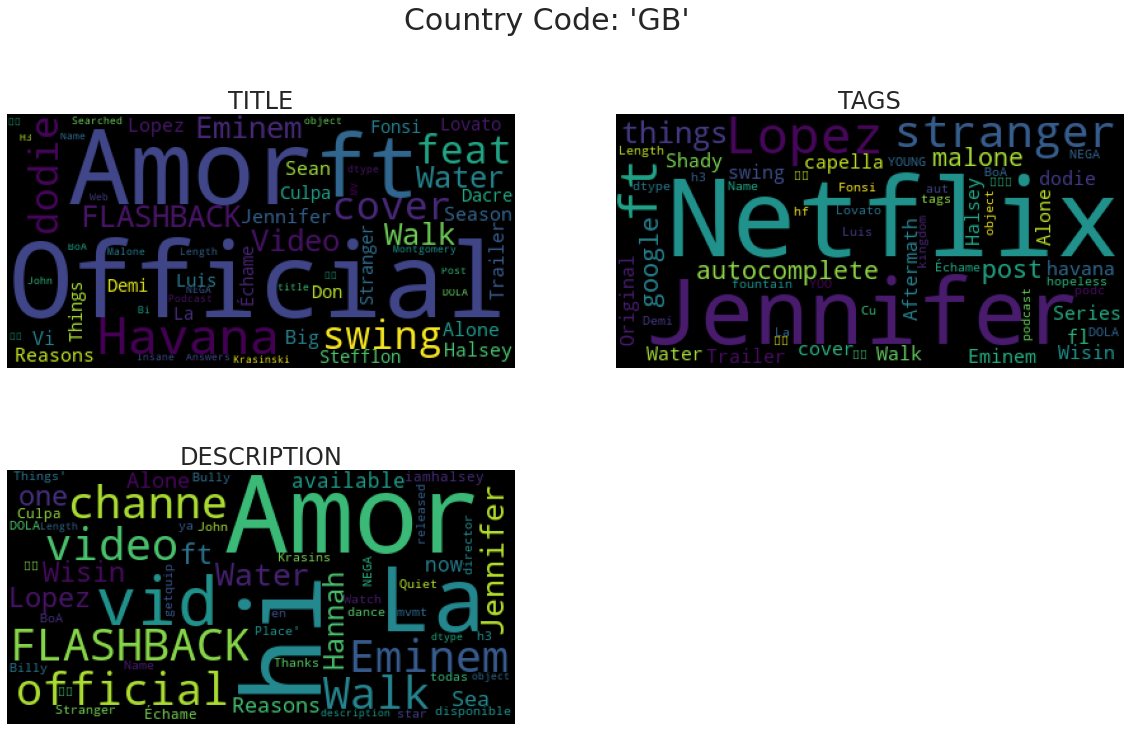

In [63]:
plot_countrywise('GB')

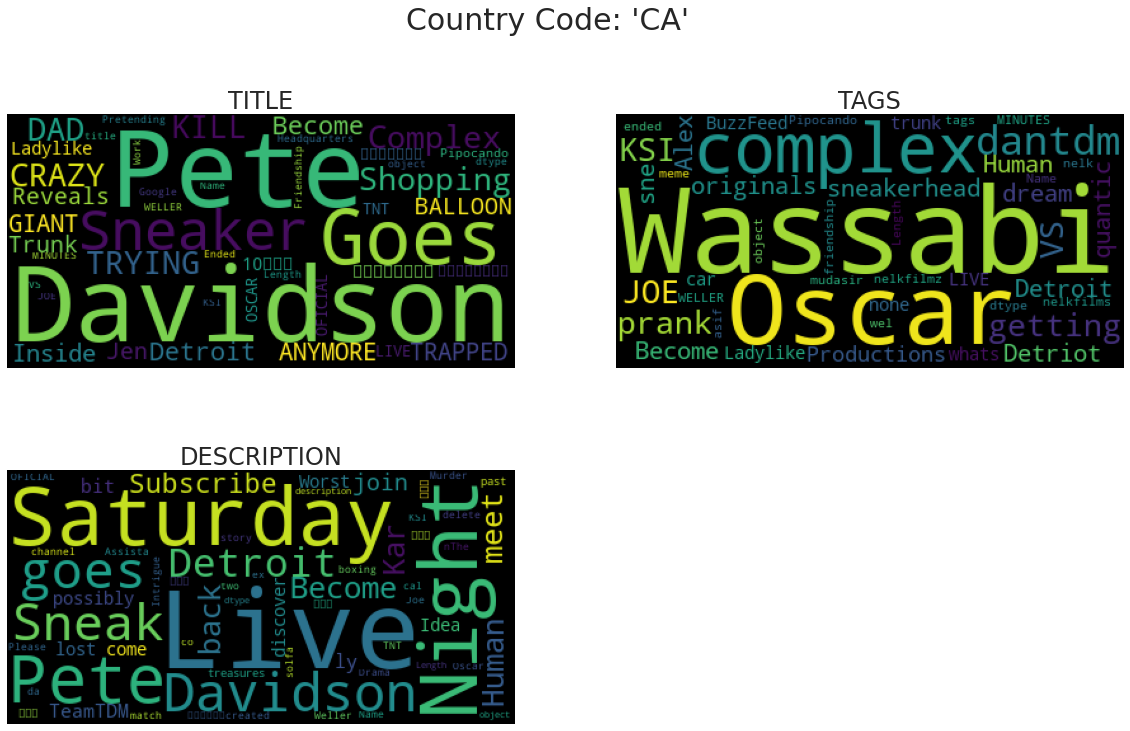

In [64]:
plot_countrywise('CA')

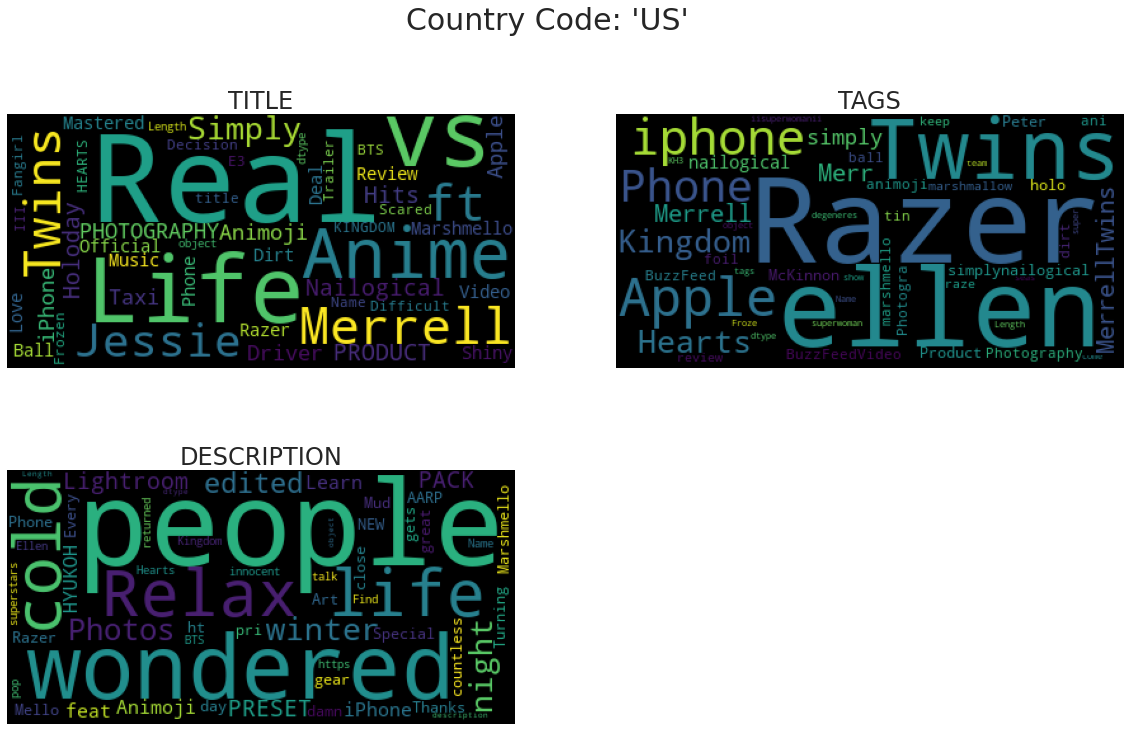

In [65]:
plot_countrywise('US')

### Length of the title, description and tags

<AxesSubplot:>

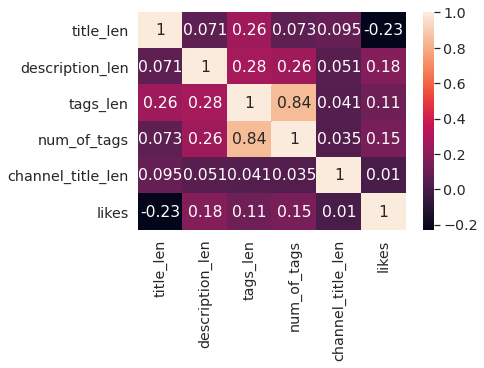

In [66]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['description_len'] = train['description'].apply(lambda x: len(x))
train['tags_len'] = train['tags'].apply(lambda x: len(x))
train['num_of_tags'] = train['tags'].apply(lambda x: len(x.split('|')))
train['channel_title_len'] = train['channel_title'].apply(lambda x: len(x))

sns.heatmap(train[['title_len', 'description_len', 'tags_len','num_of_tags', 'channel_title_len', 'likes']].corr(), annot = True)

Likes seem to have a significant negative correlation with the length of the title and a positive one with the length of the description and the number of tags. The length of the channel title seems less relevant.

# Feature engineering

In [67]:
train_test.head(2)

video_id                                              title  \
0     53364  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...   
1     51040  It's Showtime Miss Q & A: Bela gets jealous of...   

           channel_title  category_id publish_date  \
0                 HUM TV         24.0   2017-12-12   
1  ABS-CBN Entertainment         24.0   2018-03-08   

                                                tags      views  dislikes  \
0  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...  12.769769  5.700444   
1  ABS-CBN Entertainment|"ABS-CBN"|"ABS-CBN Onlin...  13.042257  4.317488   

   comment_count                                        description  \
0       6.803505  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...   
1       5.752573  Vice Ganda notices Bela Padilla's sudden chang...   

  country_code  
0           CA  
1           CA

## Numerical data

Based on the data about views, comments and dislikes we can create new features indicating the mean, max, min, sum and median values of these metrics.

In [68]:
train_test['channel_title_mean_views'] = train_test.groupby('channel_title')['views'].transform('mean')
train_test['channel_title_max_views'] = train_test.groupby('channel_title')['views'].transform('max')
train_test['channel_title_min_views'] = train_test.groupby('channel_title')['views'].transform('min')
train_test['channel_title_sum_views'] = train_test.groupby('channel_title')['views'].transform('sum')
train_test['channel_title_median_views'] = train_test.groupby('channel_title')['views'].transform('median')

In [69]:
train_test['channel_title_mean_comments'] = train_test.groupby('channel_title')['comment_count'].transform('mean')
train_test['channel_title_max_comments'] = train_test.groupby('channel_title')['comment_count'].transform('max')
train_test['channel_title_min_comments'] = train_test.groupby('channel_title')['comment_count'].transform('min')
train_test['channel_title_sum_comments'] = train_test.groupby('channel_title')['comment_count'].transform('sum')
train_test['channel_title_median_comments'] = train_test.groupby('channel_title')['comment_count'].transform('median')

In [70]:
train_test['channel_title_mean_dislikes'] = train_test.groupby('channel_title')['dislikes'].transform('mean')
train_test['channel_title_max_dislikes'] = train_test.groupby('channel_title')['dislikes'].transform('max')
train_test['channel_title_min_dislikes'] = train_test.groupby('channel_title')['dislikes'].transform('min')
train_test['channel_title_sum_dislikes'] = train_test.groupby('channel_title')['dislikes'].transform('sum')
train_test['channel_title_median_dislikes'] = train_test.groupby('channel_title')['dislikes'].transform('median')

In [71]:
# remake the train set to check the correlations of the new features with the target 
train = pd.concat((train_test[:ntrain],y_train),axis=1)

### Features derived from views

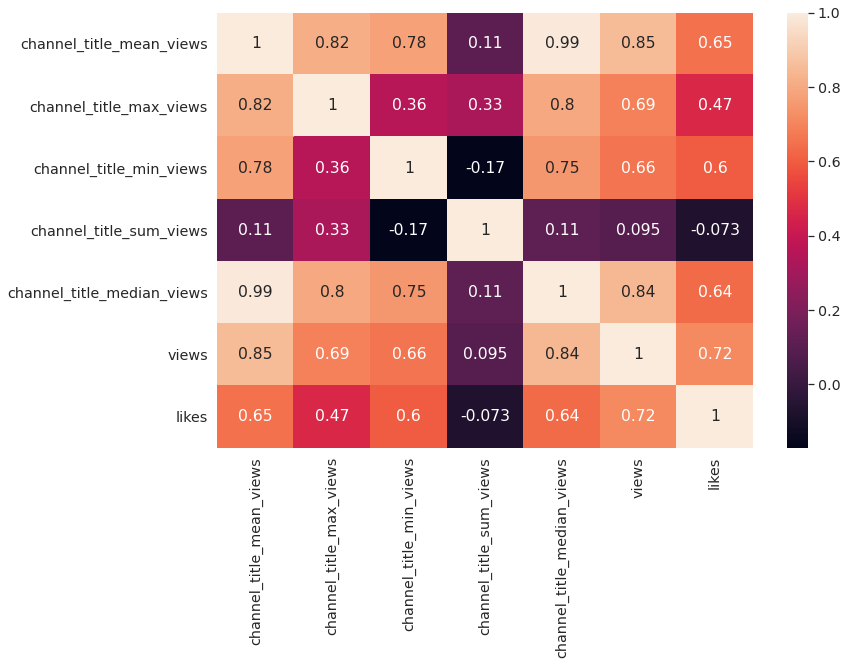

In [72]:
feats = ['channel_title_mean_views', 'channel_title_max_views', 'channel_title_min_views', 
         'channel_title_sum_views', 'channel_title_median_views', 'views', 'likes']
plot_heatmap(feats)

It can be seen that all of the new features aside from the sum of the views correlate pretty strongly with the number of likes so they may be useful for the model.

### Features derived from comments

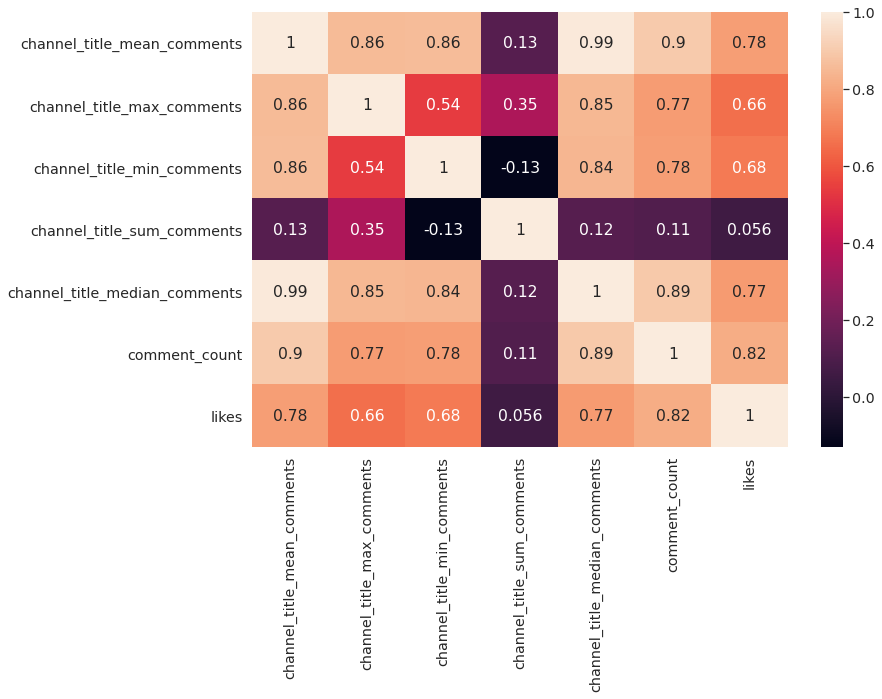

In [73]:
feats = ['channel_title_mean_comments', 'channel_title_max_comments', 'channel_title_min_comments', 
         'channel_title_sum_comments', 'channel_title_median_comments', 'comment_count', 'likes']
plot_heatmap(feats)

Similarly like for the views, only the sum of the comments appears to not be potentially useful.

### Features derived from dislikes

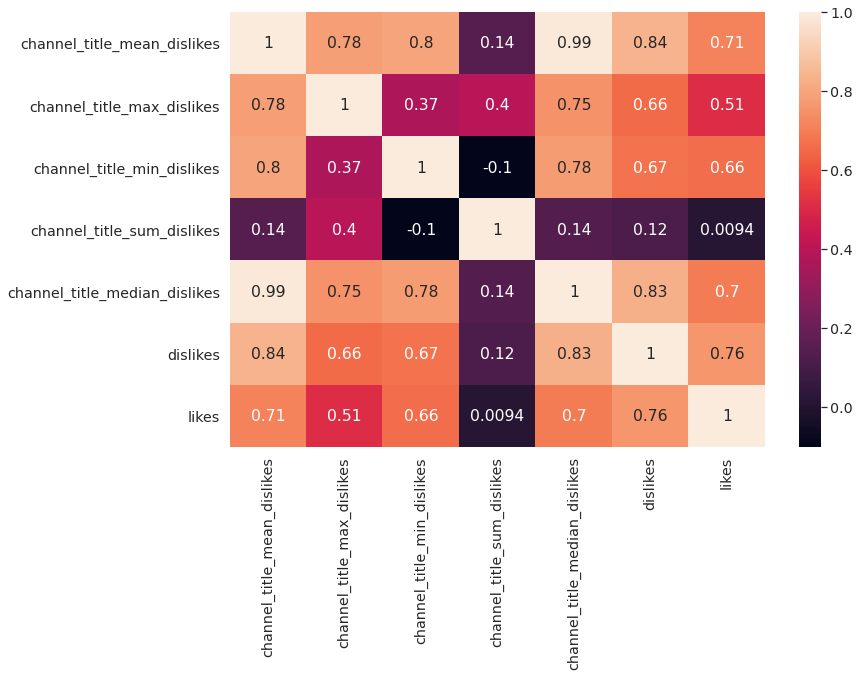

In [74]:
feats = ['channel_title_mean_dislikes', 'channel_title_max_dislikes', 'channel_title_min_dislikes', 
         'channel_title_sum_dislikes', 'channel_title_median_dislikes', 'dislikes', 'likes']
plot_heatmap(feats)

Once again, only the sum of the dislikes does not correlate with the like count.

### Total number of videos per channel

In [75]:
train_test['num_of_videos'] = train_test.groupby('channel_title')['views'].transform('count')

### Total number of videos per date

In [76]:
train_test['num_of_videos_per_date'] = train_test.groupby('publish_date')['views'].transform('count')

### In how many countries does the channel offer its videos?

In [77]:
# number of unique country codes for each channel
country_count = train_test.groupby(('channel_title'))['country_code'].nunique()

In [78]:
train_test['num_of_countries'] = train_test['channel_title'].map(country_count)

In [79]:
# remake the train set to check the correlations of the new features with the target 
train = pd.concat((train_test[:ntrain],y_train),axis=1)

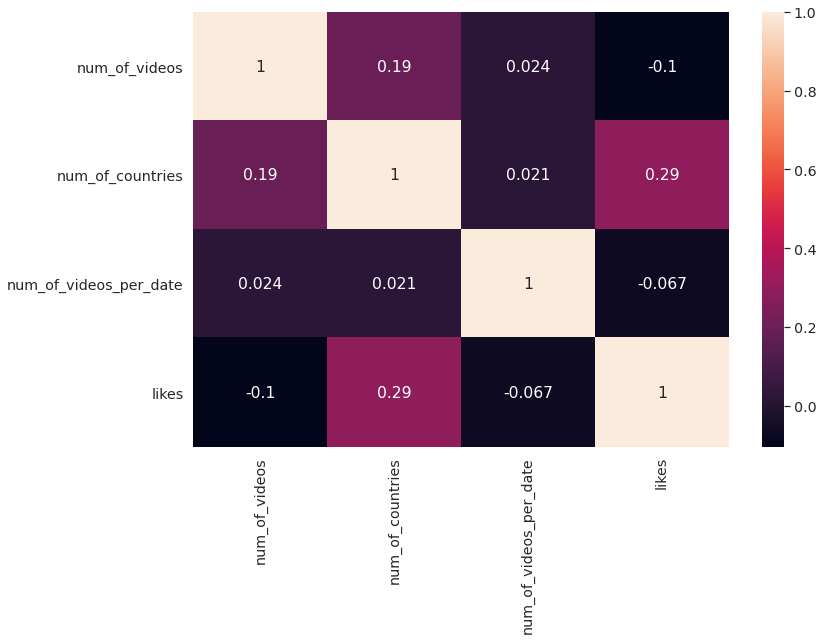

In [80]:
feats = ['num_of_videos', 'num_of_countries','num_of_videos_per_date', 'likes']
plot_heatmap(feats)

Total number of videos per channel and per date seems to have only a weak negative correlation with the number of likes, number of countries in which the channel is active seems to be a more useful feature.

## Categorical variables

### Day of the week on which the video was published

In [81]:
train_test['dayofweek'] = train_test['publish_date'].dt.day_name()

### Year of publishing

In [82]:
train_test['year'] = train_test['publish_date'].dt.year

In [83]:
train_test['year'].value_counts()

2018    26944
2017    10166
2015       24
2016       20
2011       17
2013       15
2014       12
2009       11
2012        7
2010        5
2007        5
2008        3
2006        2
Name: year, dtype: int64

Most of the videos were published in 2017 and 2018 so I'll group the rest under one category: older.

In [84]:
old_videos = train_test[train_test['publish_date'].dt.year < 2017]['publish_date'].tolist()

In [85]:
train_test['cat_year'] = train_test['year']
train_test.loc[train_test['publish_date'].isin(old_videos), 'cat_year'] = 'old'

In [86]:
train_test['cat_year'].unique()

array([2017, 2018, 'old'], dtype=object)

### Month of publishing

In [87]:
train_test['month'] = train_test['publish_date'].dt.month_name()

## Natural Language Processing feature engineering

### Text preprocessing

In [88]:
import nltk
from nltk.corpus import stopwords 
import re

In [89]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kamilkuzniak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [90]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/kamilkuzniak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [91]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True):

    lst_stopwords = stopwords.words("english")
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()    
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [92]:
train_test["clean_title"] = train_test["title"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))
train_test["clean_tags"] = train_test["tags"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))
train_test["clean_description"] = train_test["description"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))

## NLP modelling

In [93]:
# putting all of the text in a single column for the transformer model
text = train_test[['clean_title','clean_description','clean_tags']].reset_index(drop=True)
text = text.values.tolist()
text = pd.Series(text)

In [94]:
# creating the dataset for the transformer model
x_train = text[:ntrain]
y_train = train[target]
X_test = text[ntrain:]
train_data = pd.concat((x_train,y_train),axis=1)
train_data.columns = ["text", "labels"]
train_data.head()

text     labels
0  [alif allah aur insaan episode 34 hum tv drama...   7.763021
1  [showtime miss q bela get jealous ate girl, vi...   8.091015
2  [ದರಶನ ಗ ಬರ ಅವಮನ ಮಡದ ಶವಣಣ ನಯಕ n ಕಲಕ ಮಡ ನಡ ನವ da...   6.364751
3  [havana swing cover dodie feat flashback, hi h...  11.323869
4  [mummy ne ni kehta 2 ft 102 dude seriously, bo...   8.176954

In [ ]:
from simpletransformers.classification import (
    ClassificationModel, ClassificationArgs
)
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
model_args = ClassificationArgs()
model_args.num_train_epochs = 5
model_args.regression = True
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.output_dir = '../tmp/'
model_args.overwrite_output_dir = True
model_args.cache_dir = '../tmp/cache/'
model_args.best_model_dir = "../tmp/best_model/"

In [ ]:
# using the crossvalidation to create an additional feature to use in later models
n=5
kf = KFold(n_splits=n, shuffle=True)

oofs = np.zeros((len(train_data)))

for fold_, (train_index, val_index) in enumerate(kf.split(x_train,y_train)):
    print(f'\n------------- Fold {fold_ + 1} -------------')
    
  # splitting Dataframe 
    train_df = train_data.iloc[train_index]
    val_df = train_data.iloc[val_index]
    
    # Defining Model
    model = ClassificationModel('roberta', model_name='roberta-base',num_labels=1,use_cuda=True,args=model_args)

  # train the model
    model.train_model(train_df)
    
    preds_val, raw_outputs = model.predict(val_df.reset_index()['text'])
    oofs[val_index] = preds_val


In [ ]:
predictions, raw_outputs = model.predict(X_test.reset_index(drop=True))

In [ ]:
# saving the results in a csv file
preds_transformer = pd.DataFrame(predictions)
#preds_transformer = np.expm1(preds_transformer)
preds_transformer.to_csv('preds_transformer.csv', index=False)
submit_file(preds_transformer, filename='hacklive_transformer.csv')
oofs_df = pd.DataFrame(oofs)
oofs_df.to_csv('oofs_transformer.csv', index=False)

In [95]:
train_test['nlp_preds'] = pd.read_csv('ensemble_data/oofs_transformer.csv')

### Text statistics

In [97]:
#Word Count
train_test['clean_title_word_count'] = train_test["clean_title"].apply(lambda x: len(str(x).split(" ")))
train_test['clean_tags_word_count'] = train_test["clean_tags"].apply(lambda x: len(str(x).split(" ")))
train_test['clean_description_word_count'] = train_test["clean_description"].apply(lambda x: len(str(x).split(" ")))

#Character Count
train_test['clean_title_char_count'] = train_test["clean_title"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
train_test['clean_tags_char_count'] = train_test["clean_tags"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
train_test['clean_description_char_count'] = train_test["clean_description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#Average Word Length
train_test['clean_title_avg_word_length'] = train_test['clean_title_char_count'] / train_test['clean_title_word_count']
train_test['clean_tags_avg_word_length'] = train_test['clean_tags_char_count'] / train_test['clean_tags_word_count']
train_test['clean_description_avg_word_length'] = train_test['clean_description_char_count'] / train_test['clean_description_word_count']

In [98]:
# remake the train set to check the correlations of the new features with the target 
train = pd.concat((train_test[:ntrain],y_train),axis=1)

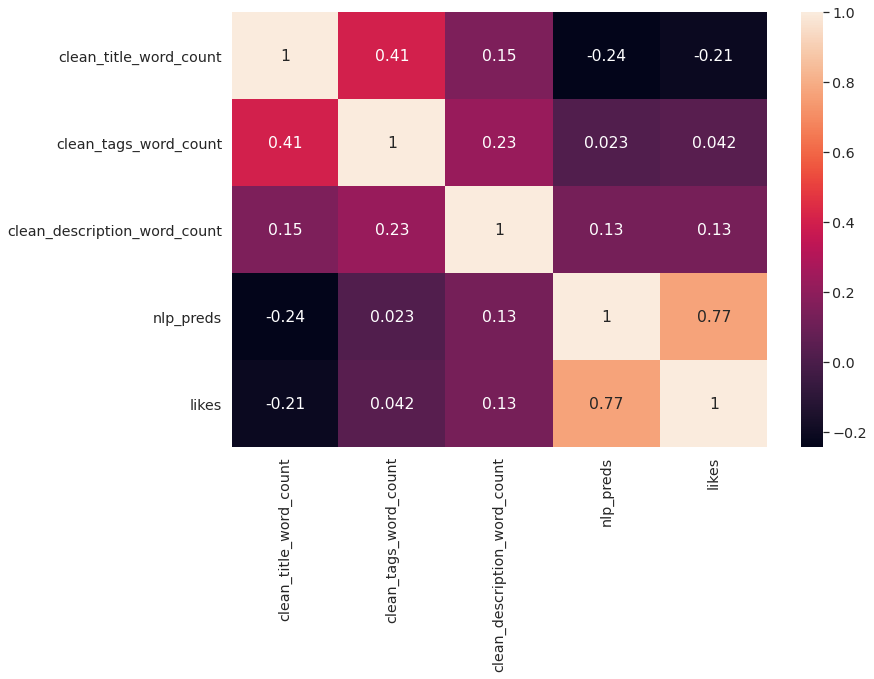

In [102]:
# heatmaps of text statistics
feats = ['clean_title_word_count', 'clean_tags_word_count','clean_description_word_count','nlp_preds', 'likes']
plot_heatmap(feats)

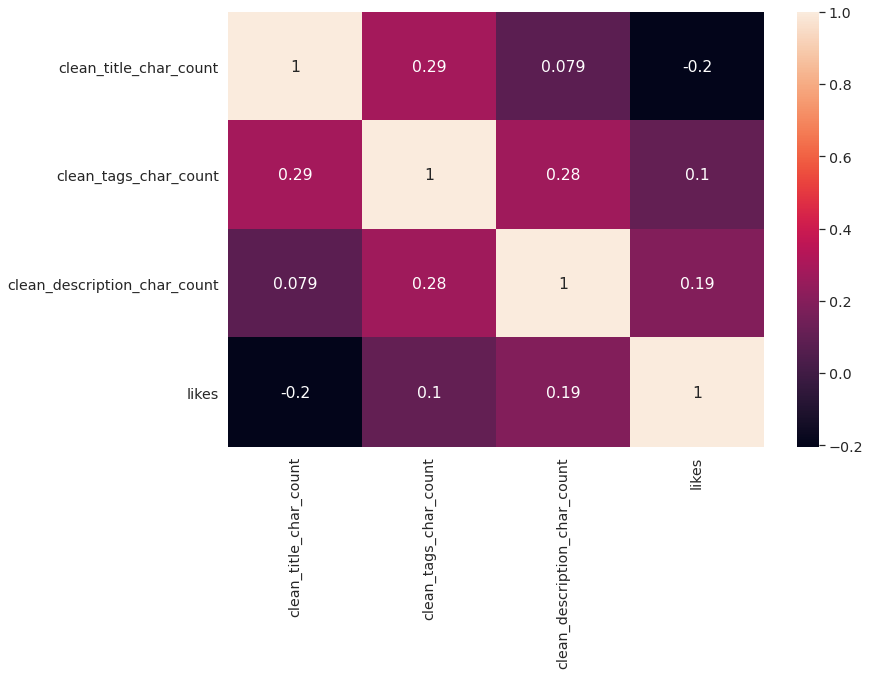

In [152]:
feats = ['clean_title_char_count', 'clean_tags_char_count','clean_description_char_count', 'likes']
plot_heatmap(feats)

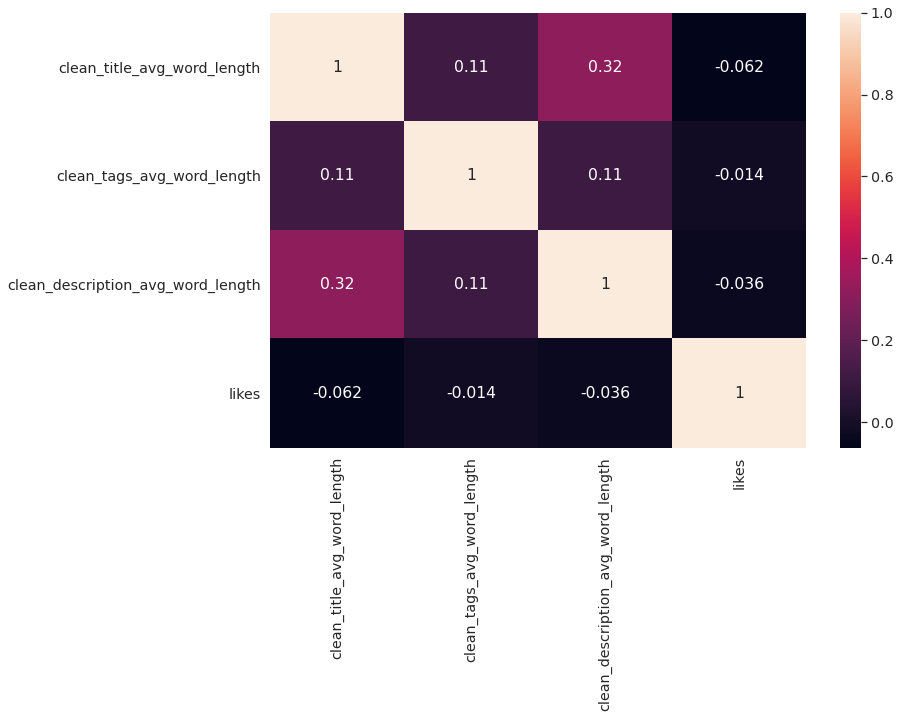

In [100]:
feats = ['clean_title_avg_word_length', 'clean_tags_avg_word_length','clean_description_avg_word_length', 'likes']
plot_heatmap(feats)

The predictions from the NLP has a strong correlation with the number of likes. The clean title word count and the clean description word count seem to have some correlation with the target variable. The rest of the new features have nearly no correlation with the number of likes.

# Finalizing the dataset

In [103]:
# keeping data with all columns, just in case
all_data = train_test.copy()

In [104]:
train_test = all_data.copy()

In [105]:
train_test.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'channel_title_mean_views', 'channel_title_max_views',
       'channel_title_min_views', 'channel_title_sum_views',
       'channel_title_median_views', 'channel_title_mean_comments',
       'channel_title_max_comments', 'channel_title_min_comments',
       'channel_title_sum_comments', 'channel_title_median_comments',
       'channel_title_mean_dislikes', 'channel_title_max_dislikes',
       'channel_title_min_dislikes', 'channel_title_sum_dislikes',
       'channel_title_median_dislikes', 'num_of_videos',
       'num_of_videos_per_date', 'num_of_countries', 'dayofweek', 'year',
       'cat_year', 'month', 'clean_title', 'clean_tags', 'clean_description',
       'nlp_preds', 'clean_title_word_count', 'clean_tags_word_count',
       'clean_description_word_count', 'clean_title_char_count',
       'clean_tags_char_count', 

In [108]:
# dropping useless features
feats = ['video_id','title','clean_title','channel_title','publish_date','tags','clean_tags','description',
         'clean_description']
train_test.drop(feats, axis=1, inplace=True)

In [109]:
train_test.columns

Index(['category_id', 'views', 'dislikes', 'comment_count', 'country_code',
       'channel_title_mean_views', 'channel_title_max_views',
       'channel_title_min_views', 'channel_title_sum_views',
       'channel_title_median_views', 'channel_title_mean_comments',
       'channel_title_max_comments', 'channel_title_min_comments',
       'channel_title_sum_comments', 'channel_title_median_comments',
       'channel_title_mean_dislikes', 'channel_title_max_dislikes',
       'channel_title_min_dislikes', 'channel_title_sum_dislikes',
       'channel_title_median_dislikes', 'num_of_videos',
       'num_of_videos_per_date', 'num_of_countries', 'dayofweek', 'year',
       'cat_year', 'month', 'nlp_preds', 'clean_title_word_count',
       'clean_tags_word_count', 'clean_description_word_count',
       'clean_title_char_count', 'clean_tags_char_count',
       'clean_description_char_count', 'clean_title_avg_word_length',
       'clean_tags_avg_word_length', 'clean_description_avg_word_length

In [110]:
# Processing categorical columns
cat_cols = ['category_id','country_code','dayofweek','cat_year','month']
train_test = pd.get_dummies(train_test, columns=cat_cols)

In [111]:
x_train = train_test[:ntrain]
y_train = train['likes']
test = train_test[ntrain:]

In [112]:
x_train.shape

(26061, 75)

# Models

### Feature selection

In [182]:
# Which features to use for modelling
features = ['views', 'dislikes', 'comment_count', 'channel_title_mean_views',
       'channel_title_max_views', 'channel_title_min_views',
       'channel_title_sum_views', 'channel_title_median_views',
       'channel_title_mean_comments', 'channel_title_max_comments',
       'channel_title_min_comments', 'channel_title_sum_comments',
       'channel_title_median_comments', 'channel_title_mean_dislikes',
       'channel_title_max_dislikes', 'channel_title_min_dislikes',
       'channel_title_sum_dislikes', 'channel_title_median_dislikes',
       'num_of_videos', 'num_of_videos_per_date', 'num_of_countries', 'year',
       'nlp_preds', 'clean_title_word_count', 'clean_tags_word_count',
       'clean_description_word_count', 'clean_title_char_count',
       'clean_tags_char_count','clean_description_char_count',
       'clean_title_avg_word_length', 'clean_tags_avg_word_length',
       'clean_description_avg_word_length','category_id_1.0',
       'category_id_2.0', 'category_id_10.0', 'category_id_15.0',
       'category_id_17.0', 'category_id_19.0', 'category_id_20.0',
       'category_id_22.0', 'category_id_23.0', 'category_id_24.0',
       'category_id_25.0', 'category_id_26.0', 'category_id_27.0',
       'category_id_28.0', 'category_id_29.0', 'category_id_30.0',
       'category_id_43.0', 'country_code_CA', 'country_code_GB',
       'country_code_IN', 'country_code_US', 'dayofweek_Friday',
       'dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday',
       'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday',
       'cat_year_2017', 'cat_year_2018', 'cat_year_old', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September']

### XGB model

In [183]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=2000,
                             #reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, 
                             random_state =7, nthread = -1, n_iter_no_change=5, tol=0.01)

In [184]:
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

In [185]:
X_trn, X_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


------------- Fold 1 -------------
[14:42:57] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter_no_change, tol } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:7.13761
Will train until validation_0-rmse hasn't improved in 200 rounds.
[300]	validation_0-rmse:0.53039
[600]	validation_0-rmse:0.50450
[900]	validation_0-rmse:0.49577
[1200]	validation_0-rmse:0.48995
[1500]	validation_0-rmse:0.48623
[1800]	validation_0-rmse:0.48518
[1999]	validation_0-rmse:0.48498

AV metric score for validation set is 484.8641618587685

------------- Fold 2 -------------
[14:44:36] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter_no_change, tol } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down t

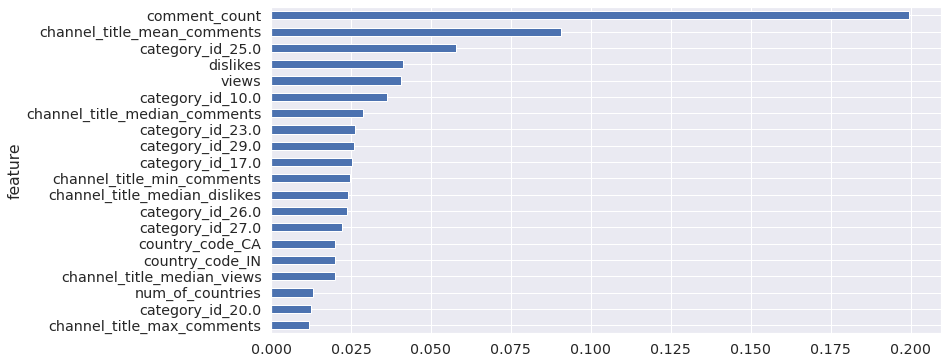

In [186]:
oofs_xgb,preds_xgb,fi_xgb = run_gradient_boosting(model_xgb, fit_params, x_train, test, features, y_train, N_SPLITS = 5)

### LGBM model

In [187]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.05, n_estimators=3000,
                              max_bin = 40, bagging_fraction = 0.8,
                              bagging_freq = 10, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 13,colsample_bytree = 1.0)
                              #n_iter_no_change=5, tol=0.01)

In [188]:
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.54889	valid_0's l2: 0.30128
[600]	valid_0's rmse: 0.520976	valid_0's l2: 0.271416
[900]	valid_0's rmse: 0.509621	valid_0's l2: 0.259713
[1200]	valid_0's rmse: 0.502289	valid_0's l2: 0.252294
[1500]	valid_0's rmse: 0.497442	valid_0's l2: 0.247449
[1800]	valid_0's rmse: 0.494301	valid_0's l2: 0.244334
[2100]	valid_0's rmse: 0.492367	valid_0's l2: 0.242426
[2400]	valid_0's rmse: 0.490554	valid_0's l2: 0.240644
[2700]	valid_0's rmse: 0.489123	valid_0's l2: 0.239241
[3000]	valid_0's rmse: 0.488436	valid_0's l2: 0.238569
Did not meet early stopping. Best iteration is:
[2994]	valid_0's rmse: 0.488409	valid_0's l2: 0.238543

AV metric score for validation set is 488.40868222366

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.547868	valid_0's l2: 0.30016
[600]	valid_0's rmse: 0.517354	valid_0's l2: 0.2

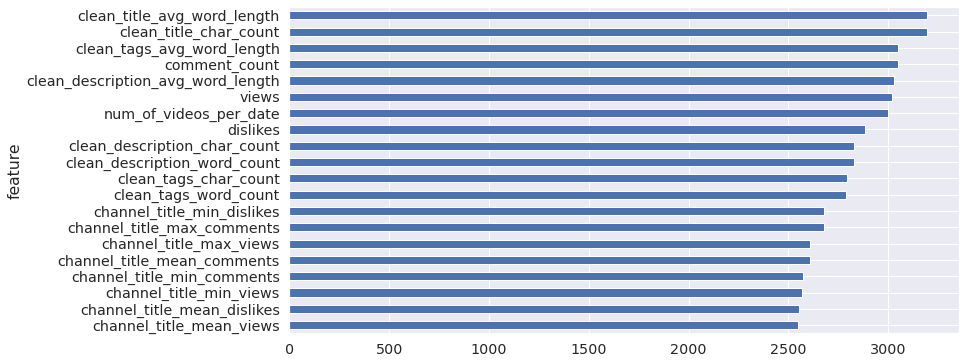

In [189]:
oofs_lgb,preds_lgb,fi_lgb = run_gradient_boosting(model_lgb, fit_params, x_train, test, features, y_train, N_SPLITS = 5)

### CatBoost model

In [190]:
model_catb = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.1,
                       rsm = 0.2, ## Analogous to colsample_bytree
                       #random_state=2054, od_type='Iter', od_wait=10
                       )

In [191]:
fit_params = {'verbose': 300, 'early_stopping_rounds': 200}


------------- Fold 1 -------------
0:	learn: 1.8009512	test: 1.7948932	best: 1.7948932 (0)	total: 2.79ms	remaining: 8.35s
300:	learn: 0.4915529	test: 0.5516989	best: 0.5516989 (300)	total: 778ms	remaining: 6.98s
600:	learn: 0.4210852	test: 0.5216209	best: 0.5215713 (597)	total: 1.62s	remaining: 6.46s
900:	learn: 0.3755563	test: 0.5062036	best: 0.5061904 (899)	total: 2.48s	remaining: 5.79s
1200:	learn: 0.3402678	test: 0.4980236	best: 0.4980236 (1200)	total: 3.32s	remaining: 4.98s
1500:	learn: 0.3126534	test: 0.4930450	best: 0.4930450 (1500)	total: 4.12s	remaining: 4.12s
1800:	learn: 0.2884673	test: 0.4891237	best: 0.4891237 (1800)	total: 4.98s	remaining: 3.31s
2100:	learn: 0.2681905	test: 0.4866996	best: 0.4866996 (2100)	total: 5.9s	remaining: 2.52s
2400:	learn: 0.2505029	test: 0.4855029	best: 0.4854767 (2395)	total: 6.69s	remaining: 1.67s
2700:	learn: 0.2344372	test: 0.4845319	best: 0.4844918 (2694)	total: 7.47s	remaining: 827ms
2999:	learn: 0.2203429	test: 0.4836323	best: 0.4836323 (

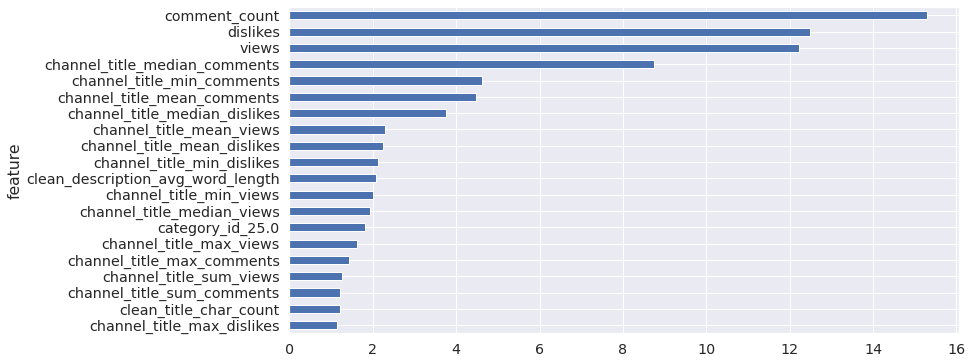

In [192]:
oofs_catb,preds_catb,fi_catb = run_gradient_boosting(model_catb, fit_params, x_train, test, features, y_train, N_SPLITS = 5)

## Hyperparameter tuning

### XGB model

In [ ]:
hyperparam_combs = {
    'colsample_bytree': [0.2,0.3,0.4,0.5,0.6],
    'gamma': [0.0,0.04, 0.08, 0.1, 0.2, 0.3,0.4],
    'learning_rate': [0.01,0.05, 0.1, 0.15, 0.2],
    'max_depth': [2,4, 6, 8, 10, 12,16,32],
    'min_child_weight': [1,1.5,2,2.5,3,4,5],
    'n_estimators': [500,1000,2000,3000,4000],
}

clf = RandomizedSearchCV(xgb.XGBRegressor(),
                         hyperparam_combs,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(x_train, y_train)

search.best_params_

### LGBM model

In [ ]:
hyperparam_combs = {
    'num_leaves': [2,4,6,10,15,20,30],
    'learning_rate': [0.01,0.05, 0.1, 0.15, 0.2],
    'n_estimators': [500,1000,2000,3000,4000],
    'max_bin': [10,20,40,55,70,90],
    'bagging_fraction': [0.2,0.4,0.6,0.8,1.0],
    'bagging_freq': [1,5,10,15,20],
    'colsample_bytree': [0.2,0.4,0.6,0.8,1.0],
    'min_sum_hessian_in_leaf': [1,3,5,7,11,13,15],
    'min_data_in_leaf': [2,4,6,8,10,16],
}

clf = RandomizedSearchCV(lgb.LGBMRegressor(),
                         hyperparam_combs,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(x_train, y_train)

search.best_params_

### CatBoost model

In [ ]:
hyperparam_combs = {
    'rsm': [0.2,0.3,0.4,0.5,0.6],
    'learning_rate': [0.01,0.05, 0.1, 0.15, 0.2],
    'n_estimators': [500,1000,2000,3000,4000]
}

clf = RandomizedSearchCV(CatBoostRegressor(),
                         hyperparam_combs,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(x_train, y_train)

search.best_params_

# Ensemble model

In [193]:
oofs_lgb = pd.Series(oofs_lgb)
oofs_catb = pd.Series(oofs_catb)
oofs_xgb = pd.Series(oofs_xgb)

In [195]:
oofs_transformer = pd.read_csv('ensemble_data/oofs_transformer.csv')

In [194]:
preds_lgb = pd.Series(preds_lgb)
preds_catb = pd.Series(preds_catb)
preds_xgb = pd.Series(preds_xgb)

In [196]:
preds_transformer = pd.read_csv('ensemble_data/preds_transformer.csv')

In [204]:
# putting the previous predictions into a single new dataset
x_train_new = pd.concat([oofs_lgb,oofs_catb,oofs_xgb],axis=1)

test_new = pd.concat([preds_lgb,preds_catb,preds_xgb],axis=1)

In [206]:
x_train_new.columns = range(3)
test_new.columns = range(3)

In [207]:
features = x_train_new.columns

In [208]:
model_ensemble = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.05, n_estimators=3000,
                              max_bin = 40, bagging_fraction = 0.8,
                              bagging_freq = 10, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 13,colsample_bytree = 1.0)
                              #n_iter_no_change=5, tol=0.01)

In [209]:
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[82]	valid_0's rmse: 0.494062	valid_0's l2: 0.244098

AV metric score for validation set is 494.0624565652923

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.491937	valid_0's l2: 0.242002
Early stopping, best iteration is:
[105]	valid_0's rmse: 0.48977	valid_0's l2: 0.239874

AV metric score for validation set is 489.76955024475166

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.481485	valid_0's l2: 0.231828
Early stopping, best iteration is:
[130]	valid_0's rmse: 0.479675	valid_0's l2: 0.230088

AV metric score for validation set is 479.67488498326577

------------- Fold 4 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.482099	valid_0's l2: 0.232419
Early st

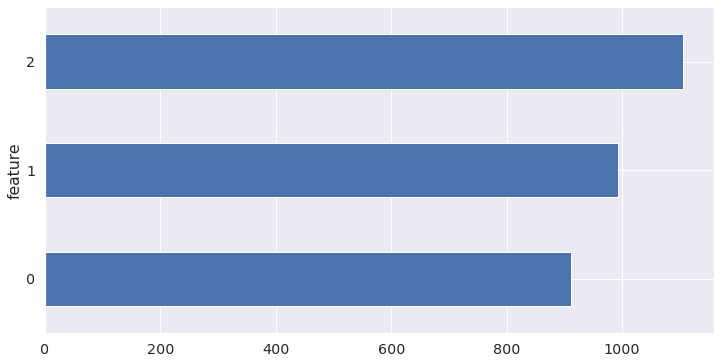

In [211]:
oofs_ensemble,preds_ensemble,fi_ensemble = run_gradient_boosting(model_ensemble, fit_params, x_train_new, test_new, features, y_train, N_SPLITS = 5)

In [212]:
preds_ensemble_final = np.expm1(preds_ensemble)

In [213]:
submit_file(preds_ensemble_final)